# Results with the raw data file - from Jupyter

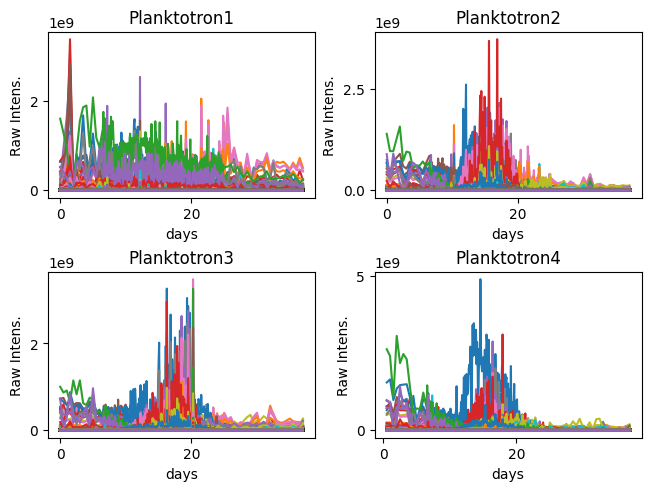

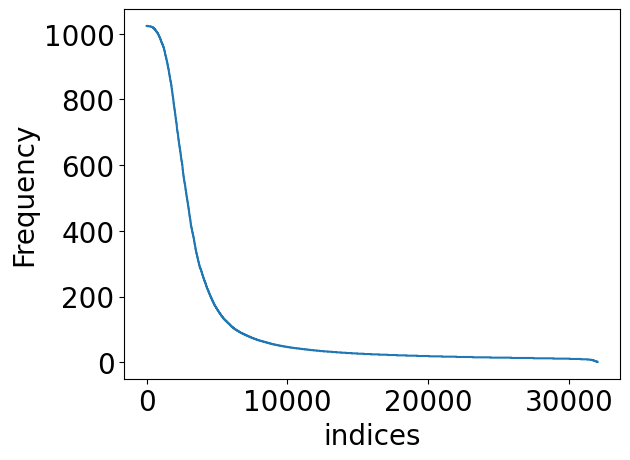

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 28 10:45:16 2023

@author: rajat
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from tqdm import tqdm

##################################################################################
plt.rcParams['figure.max_open_warning'] = 50 ## TO SET MAX. FIGs TO 50
plt.rcParams.update({'font.size': 10})
##############################################################
nclust = 3 # optimal estimated number of clusters recovered from SI score
N_floor = -4.2 # noise floor in log 10 to filter species out
SI_low_bound = 0.2 # for best clustered species
N_itr = 5 # # of iterations for SI convergence
# only change these values
#################################################################
colors = np.array(["black","green","magenta",
                   "grey","blue",
                    "cyan","orange"]) ## COLOR PALETTE
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsinitial, tsfinal = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME COLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsinitial:tsfinal] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
xlabels=list(df.columns.values)[tsinitial:tsfinal] # extracting column labels for time series 
                                         # labeling
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]    # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]    # extracting last characters
plank=np.unique(label_sub1)             # determining number of unique characters 
                                        # (planktrtrons)
nplank=len(plank)                       # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype=np.int32) # storing last digits to compare to
                                        # time points
################################################
## IMPUTING/REPLACING NaN DATA WITH THE OVERALL MEDIAN OF THE DATA SET/TIME SERIES POINT
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='mean') 
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
#useful_data = useful_data/useful_data.sum(axis=1)[:,None]
## STANDARD PROCEDURE ENDS
###############################################
# ### NOISE FILTERING
# l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
# useful_data = useful_data[:,l_mean > N_floor]
# xlab_u = xlab_u[l_mean > N_floor]
### RANK ORDER FILTER
vv = useful_data > 0
vv = vv*1
sum_array = np.sum(vv, axis=0)

useful_indx = np.where(sum_array > 0)
useful_data = useful_data.T[useful_indx].T
xlab_u = xlab_u[useful_indx] # end of rank order filtering
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
xtime = [ [] for _ in range(nplank) ] # time perplanktotron
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                    # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.double)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1
    
fig, axs = plt.subplots(2,2, constrained_layout=True)
k=-1
# fig.suptitle('Time series', fontsize=12)
for i in range(2):
    for j in range(2):
        k=k+1
        axs[i,j].plot(xtime[k], part[k], alpha=1.0)
        axs[i,j].set_title("Planktotron"+ str(k+1))
        axs[i,j].set_xlabel('days')
        axs[i,j].set_ylabel('Raw Intens.')
plt.savefig('TimeSeries.png', dpi=500)

plt.rcParams.update({'font.size': 20})

plt.figure()
plt.plot(-np.sort(-sum_array))
# plt.title('Rank order distribution')
plt.xlabel('indices')
plt.ylabel('Frequency')
plt.savefig('Rankorder.pdf')



(Above) Time-series of the proportions of the formulas in each planktotrons. (Bottom) Rank order distribution of these formulas are also shown. Since the number of formulas is quite large, these are represented by indices in descending order of their frequency, i.e. formulas occurring with higher frequencies have lower indices compared to the ones with lower frequencies.

## 2) Analysis with filters

In the following average silhouette score calculation, the following filters are implemented:

Data Preparation:
We start by filtering the overall data set using the noise floor and the rank order distribution. For the noise floor filter, we first estimate the logarithm (base 10) of time-averaged values for all formulae in our data. We then remove all formulas with values $ < -4.8$ from further analysis. With this filter, we remain with $5036$ (out of $32045$) formulas. Additionally, we rank order these as per their frequency of occurrence in all samples and only consider the ones which occur in $\ge 100$ ($\sim 10\%$) out of a total $1043$ samples. After applying this filter, we remain with a total of $5004$ chemical formulas.

### Spearman rank correlation
Is calculated by first converting the raw data values to ranks, and then calculating the Pearson correlation coefficient between the ranks. Given two variables of length $N$, the rank correlation is calculated as,

$\rho = 1 - 6 \dfrac{\sum_{i=1}^{N} d^2}{N(N^2-1)}$,

where $d$ gives the difference between the rank of the variables. Spearman rank correlation is a non-parametric test, which means that it does not make any assumptions about the distribution of the data. Additionally, it is also less sensitive to outliers/extreme values than the Pearson correlation coefficient.

### Agglomerative clustering:

Agglomerative clustering is a hierarchical clustering technique used to group similar data points into clusters in a bottom-up manner. In agglomerative clustering, individual data points are initially treated as separate clusters, and then clusters are successively merged based on their similarity until a termination condition is met. The process is summarized in the following:

1. Initialization:
Each species is initialized as an individual cluster, i.e. we start with as many clusters as there are species in the data.

2. Similarity calculation:
We calculate the pair-wise distances between all species in the data. For this, we use the metric $D_{i,j} = 1 - \rho_{i,j}$ $\forall$ $i \ne j$, where $\rho_{i,j}$ gives the Spearman's rank correlation between the time-series of species $i$ and $j$. We can hence estimate the similarity matrix as $\mathbf{D}$ $\in$ $\mathbb{R}^{N \times N}$ ($N$ is the number of species), with $D_{i,j}$ as elements, and $D_{i,j} = 0$ $\forall$ $i=j$.  

3. Merging Clusters:
Identify the two most similar clusters based on the calculated $D_{i,j}$s. These two clusters are merged into a new cluster.

4. Update similarity matrix:
The similarity matrix $\mathbf{D}$ is updated to reflect the new cluster formed in the previous step. The similarity between the newly formed cluster and other clusters is re-calculated.

5. Repeat merging and updating:
We repeat steps 4 and 5 iteratively until all data points are in a single cluster.

6. Optimal number of clusters:
To determine the optimal number of clusters, we calculate the average silhouette index for varying number of clusters, and pick the optimal value which corresponds to the highest silhouette index value. 

7. Cluster assignment:
After deciding the number of clusters, we assign data points to the final clusters.

### a) Optimal number of clusters

We use three metrics for estimating the optimal number of clusters for our data, namely,

#### 1) Silhouette index: 
Evaluates the quality of clustering results. It estimates how well each data point is assigned to its cluster, compared to how well it could be assigned to other clusters.

The silhouette index $S_i$ for $i^{th}$ chemical species is given by:

$S_i = \dfrac{(b_i - a_i)}{\max{(a_i, b_i)}}$,

where $S_i \in [-1,1]$, $a_i$ is the distance between the data point and the mean of its cluster, and $b_i$ is the smallest distance between the data point and the mean of the nearest cluster. $S_i < 0$ ($a_i > b_i$) corresponds to incorrect clustering where $S_i = -1$ ($b_i = 0$ and $a_i > 0$) gives the lower $S_i$ bound. $S_i > 0$ ($b_i > a_i$) indicates separated/stratified clusters where higher values correspond to a well separated clusters, and $S_i = 1$ ($a_i = 0$ and $b_i > 0$) gives the upper bound for the metric. $S_i \sim 0$ ($a_i = b_i$) indicates the marginal case of overlapping clusters. Generalizing this concept for a set of species $X$ of size $n(X)$ which has been clustered into $K$ clusters

$\mathrm{SI}(K) = \dfrac{1}{n(X)}\sum_{i=1}^{n(X)} S_i$,

i.e. the arithmetic mean of $S_i$s.

#### 2) Calinski-Harabasz (CH) index:
Also known as the Variance Ratio Criterion, measures the quality of clustering. It is calculated as the ratio of the between-cluster sum of squares to the within-cluster sum of squares. The Calinski-Harabasz score (CH) is defined as the ratio of the between-clusters dispersion mean and the within-cluster dispersion:

$\mathrm{CH(K)} = \dfrac{\mathrm{tr}(B_K)}{\mathrm{tr}(W_K)} \left(\dfrac{n(X) - K}{K - 1}\right)$

where $\mathrm{tr}(B_K)$ is trace of the between cluster dispersion matrix and $\mathrm{tr}(W_K)$ is the trace of the within-cluster dispersion matrix defined by:

$W_K = \sum_{i=1}^K \sum_{y \in C_i} (y - c_i) (y - c_i)^T$, and, 
$B_K = \sum_{i=1}^K n_i (c_i - c_X) (c_i - c_X)^T$

where $C_i$, $c_i$ and $n_i$ corresponds to the set of points, center, and number of points in the $i^{th}$ cluster, respectively. $c_X$ is the center of data $X$.

#### 3) Davies-Bouldin (DB) index:
Is calculated as the average of the maximum ratio of the within-cluster distance to the between-cluster distance for each cluster, and is defined as,

$\mathrm{DB(K)} = \dfrac{1}{K}\sum_{i=1}^{K} \max_{j \neq i} R_{ij}$, and

$R_{ij} = \dfrac{s_i + s_j}{d_{ij}}$, where $s_i$  corresponds to the average distance between each point in $i^{th}$ cluster and the centroid of that cluster, and $d_{ij}$ is the distance between cluster centroids $i$ and $j$. 

distance matrices done


100%|██████████| 6/6 [00:23<00:00,  3.96s/it]


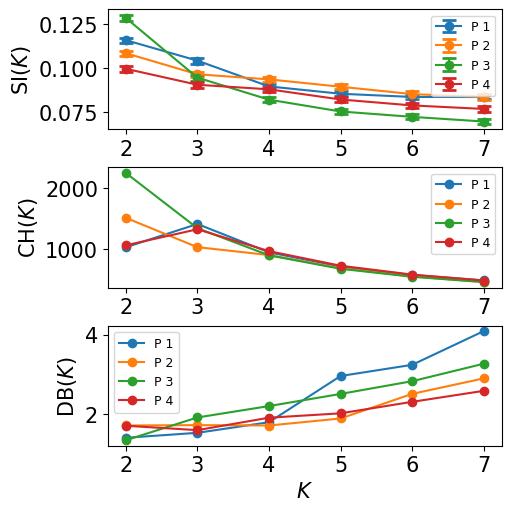

In [3]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from tqdm import tqdm
plt.rcParams['figure.max_open_warning'] = 50 ## TO SET MAX. FIGs TO 50
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.autolayout"] = True
N_floor = -4.8
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsinitial, tsfinal = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME COLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsinitial:tsfinal] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
xlabels=list(df.columns.values)[tsinitial:tsfinal] # extracting column labels for time series 
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]  # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]   # extracting last characters
plank=np.unique(label_sub1)      # determining number of unique characters 
                                      # (planktrtrons)
nplank=len(plank)                     # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype='intc') # storing last digits to compare to
                                            # time points
################################################
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='median')
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
#useful_data[np.isnan(useful_data)] = 0  ## managing nans with zeros
useful_data = useful_data/useful_data.sum(axis=1)[:,None]
###############################################
### noise filter
l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
#useful_indx = xlab[l_mean > N_floor]
useful_data = useful_data[:,l_mean > N_floor]
xlab_u = xlab_u[l_mean > N_floor]
### Rank order filter#####################
vv = useful_data > 0
vv = vv*1
sum_array = np.sum(vv, axis=0)
## to pick indices corresponding to occurrence above X (that we fix)
useful_indx = np.where(sum_array > 100)
useful_data = useful_data.T[useful_indx].T
xlab_u = xlab_u[useful_indx]
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
xtime = [ [] for _ in range(nplank) ]
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                    # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1[1:]:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.double)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1   
scaler = StandardScaler() # scaler to transform the data into z-scored data
for i in range(nplank):
    scaler.fit(part[i])
    smean=scaler.mean_
    part[i]=scaler.transform(part[i])
######### PLAYING AROUND
################################ distance matrix calculation    
xbc = [ [] for _ in range(nplank)]            # distance matrix per planktotron         
###################### parallel implementation using 4 cores
num_cores = 4
if __name__ == "__main__":
    xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
                                     for i in range(nplank))
#    xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
#                                     for i in range(nplank))
for i in range(nplank):
    xbc[i] = (1.0 - xbc[i][0])
    #np.fill_diagonal(xbc[i],0)
#    xbc[i][np.isnan(xbc[i])] = 1.0    ## to try another correlation??
print('distance matrices done')
#############################################################
nclust = 7                                 # maximum number of clusters
mean_sil_score = [ [] for _ in range(nplank)] # s score per species
sil_sem_score  = [ [] for _ in range(nplank)] # standard error for s score

dbscore = [ [] for _ in range(nplank)]
KHscore = [ [] for _ in range(nplank)]
x_axs = [] 
for K0 in tqdm(range(2,nclust+1)):
# generating cluster labels
    cluster_labels = [ [] for _ in range(nplank)] # to save cluster labels for 
                                                  # each planktotron                                         
    clusterer = AgglomerativeClustering(n_clusters=K0, metric='precomputed', 
                                        linkage='average')
    x_axs.append(K0)                                         
    for i in range(nplank):
        cluster_labels[i] = clusterer.fit_predict(xbc[i])
        sample_silhouette_values = metrics.silhouette_samples(xbc[i], 
                                                          cluster_labels[i], 
                                                          metric='precomputed',
                                                          sample_size=None, 
                                                          random_state=None)
        # Compute mean, standard deviation, and standard error
        mean_score = np.mean(sample_silhouette_values)
        std_score = np.std(sample_silhouette_values)
        sem_score = std_score / np.sqrt(len(sample_silhouette_values))

        mean_sil_score[i].append(mean_score)
        sil_sem_score[i].append(sem_score)
        
        KHscore[i].append(metrics.calinski_harabasz_score(xbc[i], 
                                                               cluster_labels[i]))
        dbscore[i].append(metrics.davies_bouldin_score(xbc[i], 
                                                            cluster_labels[i]))

mean_sil_score = np.array(mean_sil_score)
sil_sem_score = np.array(sil_sem_score)

dbscore = np.array(dbscore)
KHscore = np.array(KHscore)

fig, axs = plt.subplots(3,1,figsize=(5,5), constrained_layout=True)
for i in range(nplank):
    axs[0].errorbar(x_axs, mean_sil_score[i], yerr = sil_sem_score[i],
                    fmt ='o-', capsize = 5, 
                    capthick = 2, 
                    alpha = 1.0,
                    label = 'P '+str(i+1))
    axs[1].plot(x_axs, KHscore[i], 'o-', alpha=1.0, label='P '+str(i+1))
    axs[2].plot(x_axs, dbscore[i], 'o-', alpha=1.0, label='P '+str(i+1))

axs[0].set_xticks([2,3,4,5,6,7])
axs[1].set_xticks([2,3,4,5,6,7])
axs[2].set_xticks([2,3,4,5,6,7])    
axs[0].set_ylabel(r'$\mathrm{SI}(K)$', fontsize = 15)
axs[1].set_ylabel(r'$\mathrm{CH}(K)$', fontsize = 15)
axs[2].set_ylabel(r'$\mathrm{DB}(K)$', fontsize = 15)
axs[2].set_xlabel(r'$K$', fontsize = 15)
axs[0].legend(fontsize = 9)
axs[1].legend(fontsize = 9)
axs[2].legend(fontsize = 9)

plt.savefig('Optimal_clusters'+'.pdf')

(Top) $\mathrm{SI}(K)$, and standard error in their calculation, (middle) $\mathrm{CH}(K)$ and (bottom) $\mathrm{DB}(K)$, as a function of different number of clusters $K$ is shown for different planktotrons. Although for $\mathrm{SI}(K)$ plots, a value of $K=2$ seems more reasonable for all planktotrons. For $\mathrm{CH}(K)$ calculations, $P1$ and $P4$ show an optimal $K=3$,  and $P2$ and $P3$ show an optima $K=2$. For $\mathrm{DB}(K)$, we observe $K=3$ as an optimal cluster number for $P4$. For planktotrons $P1$ and $P3$, the $\mathrm{DB}(K)$ values for $K=2$ and $K=3$ are quite similar, and for $P2$, we get an optimal $K=2$. Based on these observations, we decide to consider $K=3$ -- which is the first non-trivial value other than $K=2$ -- as the optimal cluster number.

### b) Applying silhouette coeff. filter:


Here we calculate the dynamics of the mean (red) and median (black) (smoothened using the rolling average), van Krevelan plots and silhouette score distributions for each planktotron as well as for each cluster per planktotron. The van Krevelen plot is a graphical representation of the relationship between the hydrogen-to-carbon ratio (H/C) and the oxygen-to-carbon ratio (O/C) of organic matter. It is a useful tool for understanding the chemical composition and transformation of organic matter in a variety of environments.

In this calculation, the additional filter where we discard all species with silhouette scores > 0.1 is implemented. We repeat this calcuation for $k = 5$ iterations until we obtain a convergence to the stable silhouette score distribution. Below we show the initial ($k = 1$) and final results after implementing the filter for $k = 5$ iterations.

100%|██████████| 5/5 [00:30<00:00,  6.08s/it]


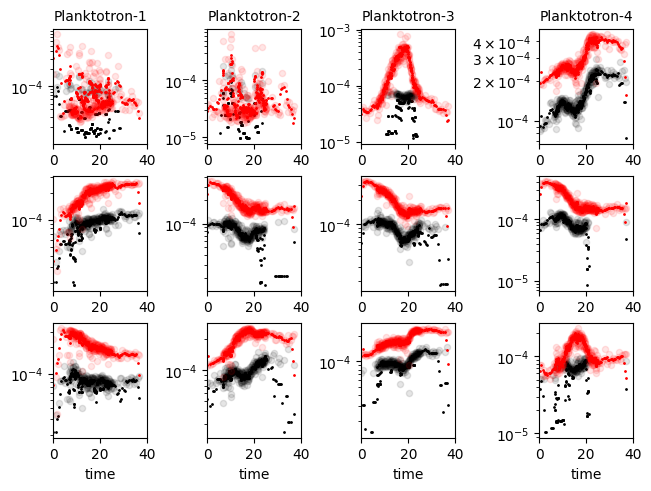

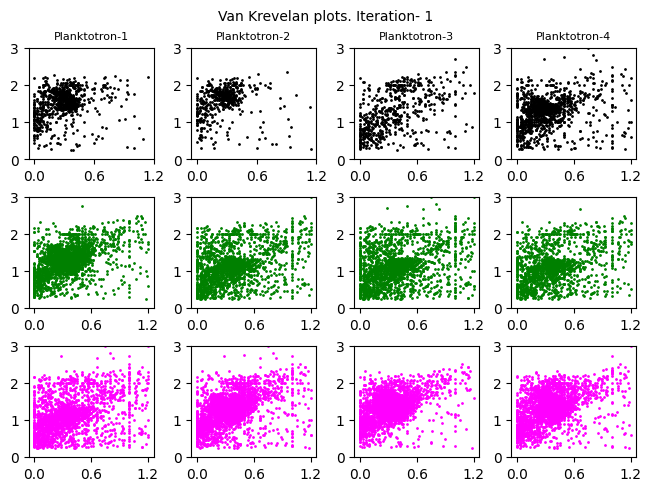

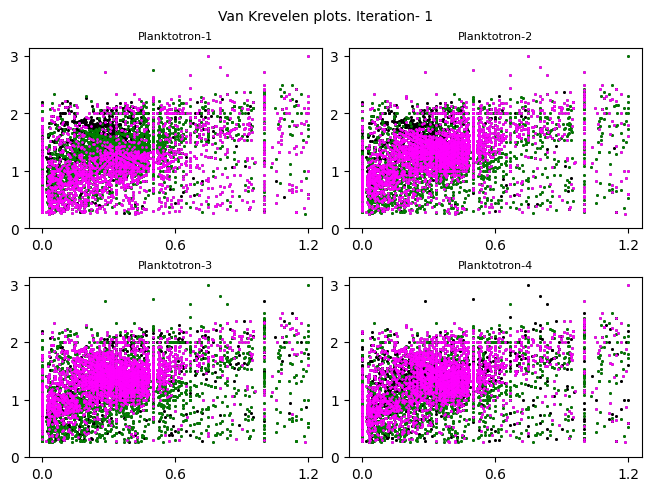

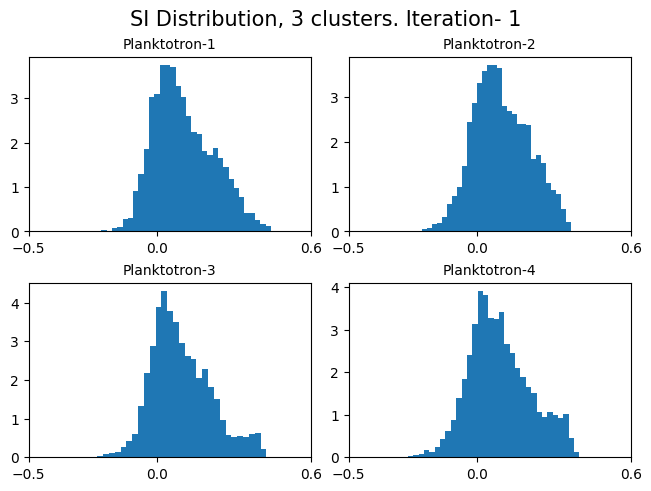

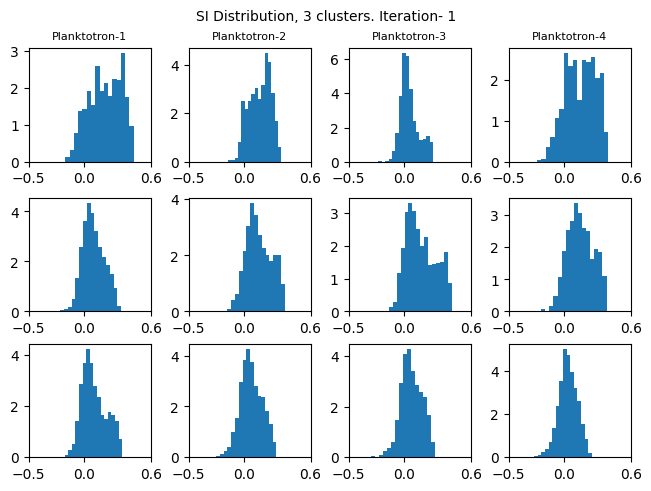

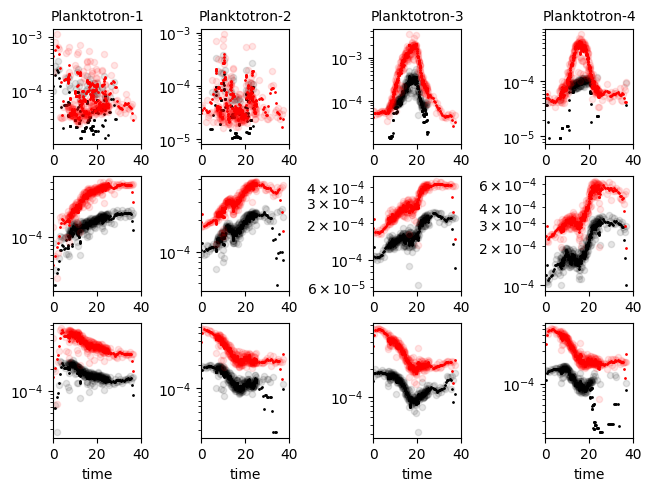

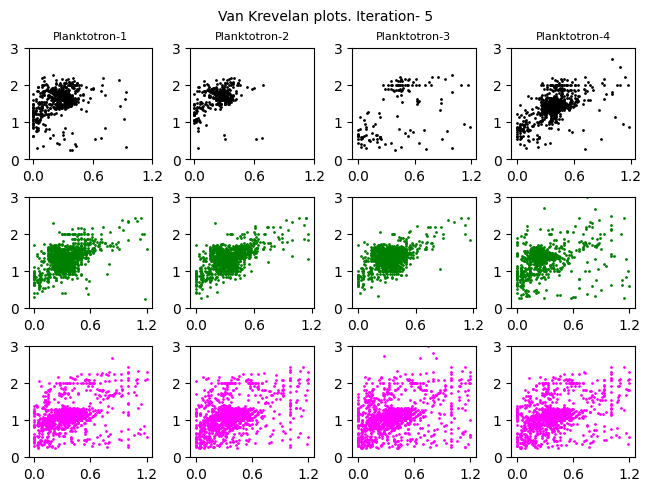

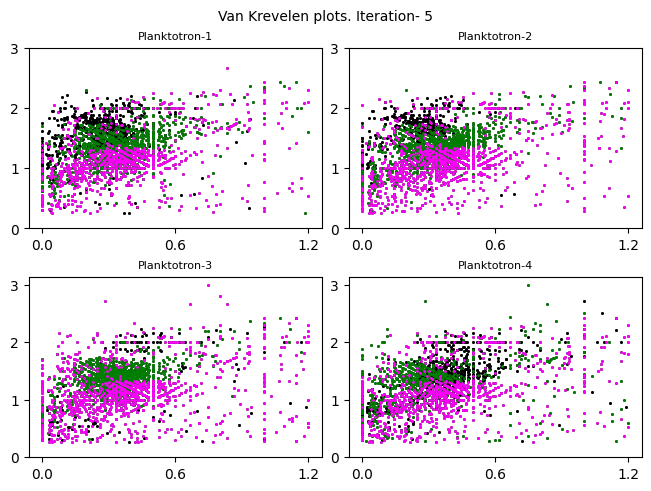

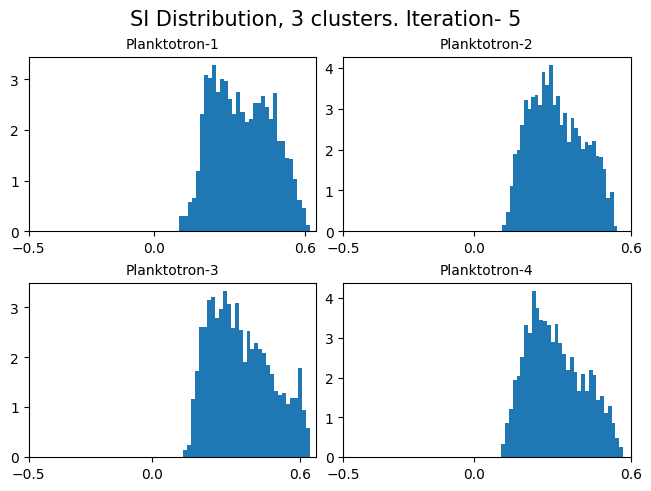

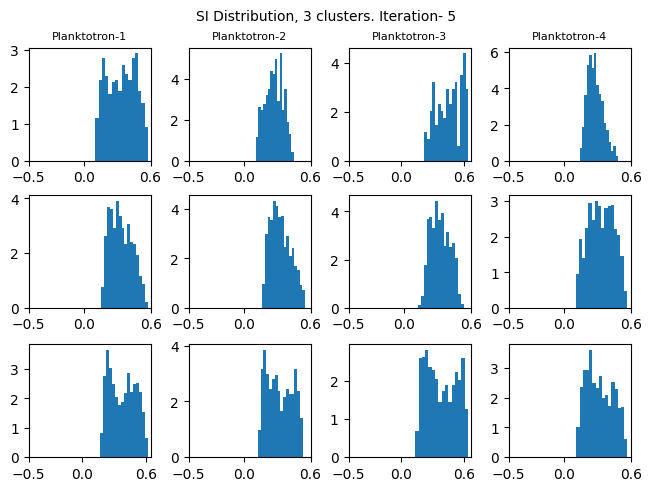

In [4]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from tqdm import tqdm
##################################################################################
plt.rcParams['figure.max_open_warning'] = 20 ## TO SET MAX. FIGs TO 50
plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.autolayout"] = True
def vankrevelan(data_array):
    # Estimating species atomic contribution in formulas
    lenspecies = len(data_array)
    data_array = [data_array[i].strip() for i in range(lenspecies)]
    global Clist
    global Hlist
    global Nlist
    global Olist
    global Plist
    global Slist
    for j in range(lenspecies):
        xtmp=[]
        cdata = data_array[j]
        #print(cdata)
        for xi in cdata: # stripping spaces
            xtmp.append(np.char.isnumeric(xi))
        xtmp=np.array(xtmp)
        xnid=np.where(xtmp==False)[0] # detecting alphabets
#        xnoid=np.where(xtmp==True)[0] # detecting numbers
        nspecies = len(xnid)
        for i in range(nspecies):
            if i < (nspecies-1):
                if (xnid[i+1]-xnid[i]) == 1:
                    globals()[cdata[xnid[i]] + "list"][j] = str(1)
                if (xnid[i+1]-xnid[i]) == 2:
                    globals()[cdata[xnid[i]] + "list"][j] = str(cdata[xnid[i]+1])
                if (xnid[i+1]-xnid[i]) == 3:
                    globals()[cdata[xnid[i]] + "list"][j] = (str(cdata[xnid[i]+1])
                                                             +str(cdata[xnid[i]+2]))
                if (xnid[i+1]-xnid[i]) == 4:
                    globals()[cdata[xnid[i]] + "list"][j] = (str(cdata[xnid[i]+1])
                                                             +str(cdata[xnid[i]+2])
                                                             +str(cdata[xnid[i]+3]))
            else:
                if (len(cdata)-xnid[i]) == 1:
                    globals()[cdata[xnid[i]] + "list"][j] = str(1)
                if (len(cdata)-xnid[i]) == 2:
                    globals()[cdata[xnid[i]] + "list"][j] = str(cdata[xnid[i]+1])
                if (len(cdata)-xnid[i])== 3:
                    globals()[cdata[xnid[i]] + "list"][j] = (str(cdata[xnid[i]+1])
                                                            +str(cdata[xnid[i]+2]))
                if (len(cdata)-xnid[i]) == 4:
                    globals()[cdata[xnid[i]] + "list"][j] = (str(cdata[xnid[i]+1])
                                                             +str(cdata[xnid[i]+2])
                                                             +str(cdata[xnid[i]+3]))
####################################################################################
def animation_fxn_1(i):  # PLOTTING FUNCTION 1
    fig, axs = plt.subplots(2,2, constrained_layout=True)
    blocks=32
    fig.suptitle('SI Distribution, '+str(nclust)+' clusters. Iteration- '+ str(i+1), fontsize=15)
    k=-1
    for ii in range(2):
        for jj in range(2):
            k = k+1
            axs[ii,jj].set_title('Planktotron-'+ str(k+1), fontsize=10)
            axs[ii,jj].hist(sscore_samp[k][i], blocks, density=True, 
                            alpha=1, label= str(i+1))
            axs[ii,jj].set_xticks([-0.5,0.0,0.6])
    plt.savefig('Sil_dist_itr_'+str(i)+'.pdf')
###################################################################################         
def animation_fxn_2(i): # PLOTTING FUNCTION 2
    fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
    blocks=16
    fig.suptitle('SI Distribution, '+str(nclust)+' clusters. Iteration- '+ str(i+1), fontsize=10)
    for ii in range(nplank):
        axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
        for jj in range(nclust):
            sscore = sscore_samp[ii][i][np.where(cluster_labels[ii]
                                                 == temp_labels[ii][jj])]
            axs[jj,ii].hist(sscore, blocks, density=True, 
                            alpha=1, label= str(i+1))
            axs[jj,ii].set_xticks([-0.5,0.0,0.6])
####################################################################################
nclust = 3 # optimal estimated number of clusters recovered from SI score
N_floor = -4.8 # noise floor in log 10 to filter species out
SI_low_bound = 0.1 # for best clustered species
N_itr = 5
# only change these values
#################################################################
colors = np.array(["black","green","magenta",
                   "grey","blue",
                    "cyan","magenta"]) ## COLOR PALETTE
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsi, tsj = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME CLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsi:tsj] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
xlabels=list(df.columns.values)[tsi:tsj] # extracting column labels for time series 
                                         # labeling
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]  # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]   # extracting last characters
plank=np.unique(label_sub1)      # determining number of unique characters 
                                      # (planktrtrons)
nplank=len(plank)                     # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype='intc') # storing last digits to compare to
                                            # time points
################################################
## IMPUTING/REPLACING NaN DATA WITH THE OVERALL MEDIAN OF THE DATA SET/TIME SERIES POINT
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='median') 
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
useful_data = useful_data/useful_data.sum(axis=1)[:,None]
## STANDARD PROCEDURE ENDS
###############################################
### NOISE FILTERING
l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
useful_data = useful_data[:,l_mean > N_floor]
xlab_u = xlab_u[l_mean > N_floor]
### RANK ORDER FILTER
vv = useful_data > 0 ## gives logical matrix with true false
vv = vv*1            ##  converting logicals to binary (0/1)
sum_array = np.sum(vv, axis=0) ##
## arranged indices
#arr_indx = np.argsort(-sum_array)
## to pick indices corresponding to occurrence above X (that we fix)
useful_indx = np.where(sum_array > 100)
useful_data = useful_data.T[useful_indx].T
xlab_u = xlab_u[useful_indx]
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
xtime = [ [] for _ in range(nplank) ]
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                    # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1[1:]:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.double)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1   
#scaler = StandardScaler() # scaler to transform the data into z-scored data
for i in range(nplank):
    xxlab[i] = xlab_u
#    scaler.fit(part[i])
#    smean=scaler.mean_
#    part[i]=scaler.transform(part[i])
######### PLAYING AROUND
num_cores = 4
sscore_samp = [ [] for _ in range(nplank)] # s score per species
sscore_av = [ [] for _ in range(nplank)]   # av. s score (av.over all species)
## CURVE SMOOTHNING PARAMETERS LATER FOR PLOTTING
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
##
for ijk in tqdm(range(N_itr)):
    ## Vankrevelan calc.
    xClist = [ [] for _ in range(nplank) ]
    xHlist = [ [] for _ in range(nplank) ]
    xNlist = [ [] for _ in range(nplank) ]
    xOlist = [ [] for _ in range(nplank) ]
    xPlist = [ [] for _ in range(nplank) ]
    xSlist = [ [] for _ in range(nplank) ]

    for i in range(nplank):
        arlen = len(xxlab[i])
        Clist= np.zeros(arlen)
        Hlist = np.zeros(arlen)
        Nlist = np.zeros(arlen)
        Olist = np.zeros(arlen)
        Plist = np.zeros(arlen)
        Slist = np.zeros(arlen)
        vankrevelan(xxlab[i])
        xClist[i].append(Clist)
        xHlist[i].append(Hlist)
        xNlist[i].append(Nlist)
        xOlist[i].append(Olist)
        xPlist[i].append(Plist)
        xSlist[i].append(Slist)
        
        xClist[i]=np.array(xClist[i], dtype=np.float32)
        xHlist[i]=np.array(xHlist[i], dtype=np.float32)
        xNlist[i]=np.array(xNlist[i], dtype=np.float32)
        xOlist[i]=np.array(xOlist[i], dtype=np.float32)
        xPlist[i]=np.array(xPlist[i], dtype=np.float32)
        xSlist[i]=np.array(xSlist[i], dtype=np.float32)
    ##################################################################
    ################################ distance matrix calculation    
    xbc = [ [] for _ in range(nplank)]            # distance matrix per planktotron         
    ###################### parallel implementation using 4 cores
    if __name__ == "__main__":
        xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
                                         for i in range(nplank))
    for i in range(nplank):
        xbc[i] = (1.0 - xbc[i][0])
    #############################################################
    # generating cluster labels
    cluster_labels = [ [] for _ in range(nplank)] # to save cluster labels for 
                                                  # each planktotron                                         
    clusterer = AgglomerativeClustering(n_clusters=nclust, 
                                        metric='precomputed', 
                                        linkage='average')                                         
    for i in range(nplank):
        cluster_labels[i] = clusterer.fit_predict(xbc[i])
        sscore_samp[i].append(metrics.silhouette_samples(xbc[i], 
                                                         cluster_labels[i], 
                                                         metric='precomputed',
                                                         sample_size=None, 
                                                         random_state=None))
        sscore_av[i].append(metrics.silhouette_score(xbc[i], 
                                                     cluster_labels[i], 
                                                     metric='precomputed',
                                                     sample_size=None, 
                                                     random_state=None))
    ###################################
    if (ijk == 0) | (ijk == N_itr-1):
    ##########################################     cluster sorting with size
        temp_labels = [0 for ii in range(nplank)]
        for i in range(nplank):
            xsize = [0 for ii in range(nclust)]
            for j in range(nclust):
                xsize[j] = np.shape(np.where(cluster_labels[i] == j))[1]
            temp_labels[i] = np.argsort(xsize)
        k1 = temp_labels[0][1]
        k2 = temp_labels[0][2]
        temp_labels[0][1] = k2
        temp_labels[0][2] = k1
    ########################################################################           
        qnt=0.25   # setting up quantiles
        touse = [[[] for i in range(nplank)] for j in range(nclust)]
        xmedian = [[[] for i in range(nplank)] for j in range(nclust)] # median array
        xmean = [[[] for i in range(nplank)] for j in range(nclust)]   # mean array
        xshn = [[[] for i in range(nplank)] for j in range(nclust)]
        xmax = [[[] for i in range(nplank)] for j in range(nclust)]
        for ii in range(nplank):
            xpart=part[ii].T
            for i in range(nclust):
                touse[i][ii] = xpart[np.where(cluster_labels[ii]==temp_labels[ii][i])]
                xmedian[i][ii] = np.median(touse[i][ii], axis = 0)
                xmean[i][ii] = np.mean(touse[i][ii], axis = 0)
        
#        fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
#        fig.suptitle(str(nclust)+ '-clusters, converged max', fontsize=10)
#        for ii in range(nplank):
#            axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
#            for i in range(nclust):
    ################################# Smoothing Data by Rolling Average with NumPy
#                cumsum_vec = np.convolve(xmax[i][ii], kernel,
#                                          mode ='same')
    ##############################################################################            
#                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='k')
#                axs[i,ii].plot(xtime[ii], xmax[i][ii],'o', markersize=np.sqrt(20.), 
#                               c='k', alpha =0.1 )
#                axs[i,ii].set_xlim([0,40])
            
        fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
        #fig.suptitle(str(nclust)+ '-clusters, mean (red), median (black). Iteration- '+ str(ijk+1), fontsize=15)
        for ii in range(nplank):
            axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=10)
            axs[2,ii].set_xlabel('time', fontsize=10)
            for i in range(nclust):
    ################################# Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(xmedian[i][ii], kernel,
                                          mode ='same')
    ##############################################################################            
                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='k')
                axs[i,ii].plot(xtime[ii], xmedian[i][ii],'o', markersize=np.sqrt(20.), 
                               c='k', alpha =0.1 )
                cumsum_vec = np.convolve(xmean[i][ii], kernel,
                                          mode ='same')
                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='r')
                axs[i,ii].plot(xtime[ii], xmean[i][ii],'o', markersize=np.sqrt(20.), 
                               c='r', alpha =0.1 )
                axs[i,ii].set_yscale('log')
                axs[i,ii].set_xlim([0,40])

        plt.savefig('Centraltend_itr_'+str(ijk+1)+'.pdf')        
            
#        fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
#        fig.suptitle(str(nclust)+ '-clusters, entropy', fontsize=10)
#        for ii in range(nplank):
#            axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
#            for i in range(nclust):
                ################################ Smoothing Data by Rolling Average with NumPy
#                cumsum_vec = np.convolve(xshn[i][ii], kernel,
#                                          mode ='same')
                ##############################################################################            
#                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='r')
#                axs[i,ii].plot(xtime[ii], xshn[i][ii],'o', markersize=np.sqrt(20.), 
#                                c='r', alpha =0.1 )
#                axs[i,ii].set_xlim([0,40])
        ################################## Van-Krevelen plots per planktotron per cluster
        if (ijk == 0) | (ijk == N_itr-1):
            fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
            fig.suptitle('Van Krevelan plots. Iteration- '+ str(ijk+1), fontsize=10)
            for ii in range(nplank):
                axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
                ppx1, ppy1 = xOlist[ii]/xClist[ii], xHlist[ii]/xClist[ii]
                for i in range(nclust):
                    ppx = ppx1[0,np.where(cluster_labels[ii] == temp_labels[ii][i])]
                    ppy = ppy1[0,np.where(cluster_labels[ii] == temp_labels[ii][i])]
                    axs[i,ii].scatter(ppx, ppy, s=1.0, c=colors[i], alpha=1)
                    axs[i,ii].set_ylim([0,3])
                    axs[i,ii].set_xticks([0,0.6,1.2])
        ################################## Van-Krevelen plots per planktotron        
            fig, axs = plt.subplots(2,2, constrained_layout=True)
            fig.suptitle('Van Krevelen plots. Iteration- '+ str(ijk+1), fontsize=10)
            k=-1
            for ii in range(2):
                for jj in range(2):
                    k = k+1
                    axs[ii,jj].set_title('Planktotron-'+ str(k+1), fontsize=8)
                    ppx1, ppy1 = xOlist[k]/xClist[k], xHlist[k]/xClist[k]
                    axs[ii,jj].scatter(ppx1, ppy1, s=1.0, c='black', alpha=1)
                    for i in range(nclust):
                        ppx = ppx1[0,np.where(cluster_labels[k] == temp_labels[k][i])]
                        ppy = ppy1[0,np.where(cluster_labels[k] == temp_labels[k][i])]
                        axs[ii,jj].scatter(ppx, ppy, s=1.0, c=colors[i], alpha=1)
                        axs[ii,jj].set_xticks([0,0.6,1.2])
                        axs[ii,jj].set_yticks([0,1,2,3])
        ##################################  S-Score plots per planktotron    
        animation_fxn_1(ijk)
        ##################################  S-Score plots per cluster per planktotron       
        animation_fxn_2(ijk)
        ##################################       
    for i in range(nplank):
        part[i] = part[i][:,sscore_samp[i][ijk] > SI_low_bound]
        #print(np.shape(part[i]))
        xxlab[i] = xxlab[i][sscore_samp[i][ijk] > SI_low_bound]

The number of formulas in each planktotrons after the $SI$ filter are : $n(P1) = 2261$, $n(P2) = 2247$, $n(P3) = 2104$, abd $n(P4) = 2092$.

### c) Comparison to deep sea DOM:
Here we estimate the Jaccard similarity and Bray-Curtis similarity of species in each cluster to the Nelha data.

#### 1. Jaccard/ presence-absence similarity:

The Jaccard distance is a metric used to quantify the dissimilarity or similarity between two sets of ecological samples, often represented as species presence or absence data. It is a measure of the proportion of unique elements in each set compared to the total number of elements present in both sets.  

******is sensitive to species richness and may not capture differences in relative abundances.

###### Black symbols correspond to cluster 1, green symbols to cluster 2 and magenta symbols to cluster 3

100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


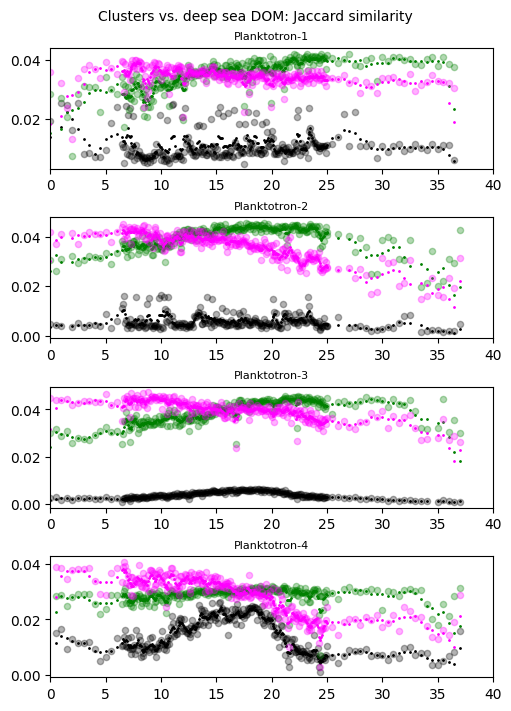

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 28 10:45:16 2023

@author: rajat
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import jaccard, hamming
from scipy import stats
from My_Functions import vankrevelan
from tqdm import tqdm

Zero = 0 #0.000001
##################################################################################
plt.rcParams['figure.max_open_warning'] = 20 ## TO SET MAX. FIGs TO 50
plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.autolayout"] = True
##############################################################
##############################################################
def jaccard_rk(a,b):
    # estimating intersection, i.e. #(1,1)s
    intsc = np.where((a == 1) & (b == 1))
    n_intsc = np.shape(intsc)[1]
    # estimating #(1,0)s
    N10 = np.where((a == 1) & (b == 0))
    n_N10 = np.shape(N10)[1]
    # estimating #(0,1)s
    N01 = np.where((a == 0) & (b == 1))
    n_N01 = np.shape(N01)[1]
    # estimating #(0,0)s
    N00 = np.where((a == 0) & (b == 0))
    n_N00 = np.shape(N00)[1]
    
    return n_intsc/(n_intsc + n_N10 + n_N01), n_intsc, n_N10, n_N01, n_N00
##################################################################
nclust = 3         # optimal estimated number of clusters recovered from SI score
N_floor = -4.8     # noise floor in log 10 to filter species out
SI_low_bound = 0.1 # for best clustered species
N_itr = 5         # of iterations for SI convergence
# only change these values
#################################################################
colors = np.array(["black","green","magenta",
                   "grey","blue",
                    "cyan","orange"]) ## COLOR PALETTE
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsi, tsj = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME CLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsi:tsj] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
xlabels=list(df.columns.values)[tsi:tsj] # extracting column labels for time series 
                                         # labeling

Nelha_start_col = 1109 # the nelha data starts here in the data file
df_Nelha = df.iloc[:,Nelha_start_col:]     # data continues till the file end
Nelha_data = np.array(df_Nelha.values, dtype = np.float32).transpose()
Nelha_binary = np.mean(Nelha_data, axis=0) # finding median of nelha data
Nelha_binary = Nelha_binary/np.sum(Nelha_binary) # calculate relative contribution
Nelha_binary[Nelha_binary > Zero] = 1.0    # making the data binary for Jaccard
Nelha_binary[Nelha_binary == Zero] = 0.0   # making the data binary for Jaccard
Nx = np.shape(Nelha_binary)[0]
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]       # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]       # extracting last characters
plank=np.unique(label_sub1)                # determining number of unique characters 
                                           # (planktotrons)
nplank=len(plank)                       # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype='intc') # storing last digits to compare to
                                        # time points
################################################
## IMPUTING/REPLACING NaN DATA WITH THE OVERALL MEDIAN OF THE DATA SET/TIME SERIES POINT
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='mean') 
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
useful_data = useful_data/useful_data.sum(axis=1)[:,None]
## STANDARD PROCEDURE ENDS
###############################################
### NOISE FILTERING
l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
useful_data = useful_data[:,l_mean > N_floor]
xlab_u = xlab_u[l_mean > N_floor]
### RANK ORDER FILTER
vv = useful_data > 0 ## gives logical matrix with true false
vv = vv*1            ##  converting logicals to binary (0/1)
sum_array = np.sum(vv, axis=0) ##
## arranged indices
#  arr_indx = np.argsort(-sum_array)
## to pick indices corresponding to occurrence above X (that we fix)
useful_indx = np.where(sum_array > 100)
useful_data = useful_data.T[useful_indx].T
#Nelha_binary = Nelha_binary[useful_indx]
xlab_u = xlab_u[useful_indx] # end of rank order filtering
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
Nelha_plnk = [ [] for _ in range(nplank)]   # Nelha per planktotron
xtime = [ [] for _ in range(nplank) ] # time perplanktotron
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                          # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1[1:]:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.double)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1
scaler = StandardScaler()     # scaler to transform the data into z-scored data
for i in range(nplank):
    xxlab[i] = xlab_u
    Nelha_plnk[i] = Nelha_binary
num_cores = 4
sscore_samp = [ [] for _ in range(nplank)] # s score per species
sscore_av = [ [] for _ in range(nplank)]   # av. s score (av.over all species)
## CURVE SMOOTHNING PARAMETERS LATER FOR PLOTTING
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
##
for ijk in tqdm(range(N_itr)):
    ############################################################# Vankrevelan calc.
    ## Vankrevelan plot calculation
    xClist = [ [] for _ in range(nplank) ]
    xHlist = [ [] for _ in range(nplank) ]
    xNlist = [ [] for _ in range(nplank) ]
    xOlist = [ [] for _ in range(nplank) ]
    xPlist = [ [] for _ in range(nplank) ]
    xSlist = [ [] for _ in range(nplank) ]

    for i in range(nplank):
        xtempvankrev = vankrevelan(xxlab[i])
        xClist[i].append(xtempvankrev['C'])
        xHlist[i].append(xtempvankrev['H'])
        xNlist[i].append(xtempvankrev['N'])
        xOlist[i].append(xtempvankrev['O'])
        xPlist[i].append(xtempvankrev['P'])
        xSlist[i].append(xtempvankrev['S'])
        
        xClist[i]=np.array(xClist[i], dtype=np.float32)
        xHlist[i]=np.array(xHlist[i], dtype=np.float32)
        xNlist[i]=np.array(xNlist[i], dtype=np.float32)
        xOlist[i]=np.array(xOlist[i], dtype=np.float32)
        xPlist[i]=np.array(xPlist[i], dtype=np.float32)
        xSlist[i]=np.array(xSlist[i], dtype=np.float32)

################################################### distance matrix calculation    
    xbc = [ [] for _ in range(nplank)]            # distance matrix per planktotron         
######################################### parallel implementation on 4 cores
    if __name__ == "__main__":
        xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
                                         for i in range(nplank))
    for i in range(nplank):
        xbc[i] = (1.0 - xbc[i][0])
        #np.fill_diagonal(xbc[i],0)
###############################################################################
    # generating cluster labels
    cluster_labels = [ [] for _ in range(nplank)] ## to save cluster labels for 
                                                  ## each planktotron                                         
    clusterer = AgglomerativeClustering(n_clusters=nclust, 
                                        metric='precomputed', 
                                        linkage='average')                                         
    for i in range(nplank):
        cluster_labels[i] = clusterer.fit_predict(xbc[i])
        sscore_samp[i].append(metrics.silhouette_samples(xbc[i], 
                                                         cluster_labels[i], 
                                                         metric='precomputed',
                                                         sample_size=None, 
                                                         random_state=None))
        sscore_av[i].append(metrics.silhouette_score(xbc[i], 
                                                     cluster_labels[i], 
                                                     metric='precomputed',
                                                     sample_size=None, 
                                                     random_state=None))
    if ijk == N_itr-1:       
    #################################################     cluster sorting with size
        temp_labels = [0 for ii in range(nplank)]
        for i in range(nplank):
            xsize = [0 for ii in range(nclust)]
            for j in range(nclust):
                xsize[j] = np.shape(np.where(cluster_labels[i] == j))[1]
            temp_labels[i] = np.argsort(xsize)
        k1 = temp_labels[0][1]
        k2 = temp_labels[0][2]
        temp_labels[0][1] = k2
        temp_labels[0][2] = k1    
    ###############################################################################           
        qnt=0.25                                                       # setting up quantiles
        touse = [[[] for i in range(nplank)] for j in range(nclust)]
        xmedian = [[[] for i in range(nplank)] for j in range(nclust)] # median array
        xmean = [[[] for i in range(nplank)] for j in range(nclust)]   # mean array
        for_dist = [[[] for i in range(nplank)] for j in range(nclust)]
        Nelha_clus = [[[] for i in range(nplank)] for j in range(nclust)]
        for ii in range(nplank):
            xpart=part[ii].T
            for i in range(nclust):
                xtemp = np.where(cluster_labels[ii]==temp_labels[ii][i])
                touse[i][ii] = xpart[xtemp]
                xmedian[i][ii] = np.median(touse[i][ii], axis = 0)
                xmean[i][ii] = np.mean(touse[i][ii], axis = 0)
                for_dist[i][ii] = np.zeros((Nx,np.shape(xpart)[1]))
                #for_dist[i][ii] = np.zeros(np.shape(xpart))
                for_dist[i][ii][xtemp] = xpart[xtemp]
                for_dist[i][ii][for_dist[i][ii] == Zero] = 0
                for_dist[i][ii][for_dist[i][ii] > Zero] = 1
                Nelha_clus[i][ii] = Nelha_binary
                
        dist_Nlhaclus = [[[] for i in range(nplank)] for j in range(nclust)]
        Nones = [[[] for i in range(nplank)] for j in range(nclust)]
        Nonezero = [[[] for i in range(nplank)] for j in range(nclust)]
        Nzeroone = [[[] for i in range(nplank)] for j in range(nclust)]
        Nzerozero = [[[] for i in range(nplank)] for j in range(nclust)]

        for ii in range(nplank):
            for i in range(nclust):
                dist_Nlhaclus[i][ii] = [jaccard_rk(Nelha_clus[i][ii], 
                                                for_dist[i][ii].T[j])[0]
                                                for j in range(np.shape
                                                               (for_dist[i][ii].T)[0])]
                Nones[i][ii] = [jaccard_rk(Nelha_clus[i][ii], 
                                                for_dist[i][ii].T[j])[1]
                                                for j in range(np.shape
                                                               (for_dist[i][ii].T)[0])]
                Nonezero[i][ii] = [jaccard_rk(Nelha_clus[i][ii], 
                                                for_dist[i][ii].T[j])[2]
                                                for j in range(np.shape
                                                              (for_dist[i][ii].T)[0])]
                Nzeroone[i][ii] = [jaccard_rk(Nelha_clus[i][ii], 
                                                for_dist[i][ii].T[j])[3]
                                                for j in range(np.shape
                                                              (for_dist[i][ii].T)[0])]
                Nzerozero[i][ii] = [jaccard_rk(Nelha_clus[i][ii], 
                                                for_dist[i][ii].T[j])[4]
                                                for j in range(np.shape
                                                              (for_dist[i][ii].T)[0])]
    ###############################################################################            
#        fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
#        fig.suptitle(str(nclust)+ '-clusters, median (black) and mean (red)', fontsize=10)
#        for ii in range(nplank):
#            axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
#            for i in range(nclust):
#    ################################### Smoothing Data by Rolling Average with NumPy
#                cumsum_vec = np.convolve(xmedian[i][ii], kernel,
#                                          mode ='same')
#    ###############################################################################            
#                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='k')
#                axs[i,ii].plot(xtime[ii], xmedian[i][ii],'o', markersize=np.sqrt(20.), 
#                                c='k', alpha =0.1 )
#                cumsum_vec = np.convolve(xmean[i][ii], kernel, 
#                                         mode ='same')
#                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='r')
#                axs[i,ii].plot(xtime[ii], xmean[i][ii],'o', markersize=np.sqrt(20.), 
#                                c='r', alpha =0.1 )
#                axs[i,ii].set_xlim([0,40])
#                axs[i,ii].set_yscale('log')
#                axs[i,ii].set_ylim([10**-5,10**-3])
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,7), constrained_layout=True)
        fig.suptitle('Clusters vs. deep sea DOM: Jaccard similarity', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(dist_Nlhaclus[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                             c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], dist_Nlhaclus[i][ii],'o', markersize=np.sqrt(20.),
                            c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])
               # axs[ii].legend()
#                axs[ii].set_ylim([0.95,1.0])
        plt.savefig('NELHASimJC'+'.pdf')
                
    for i in range(nplank):
        part[i] = part[i][:,sscore_samp[i][ijk] > SI_low_bound]
        xxlab[i] = xxlab[i][sscore_samp[i][ijk] > SI_low_bound]
       # Nelha_plnk[i] = Nelha_plnk[i][sscore_samp[i][ijk] > SI_low_bound]


These results show that: in the beginning/initial part of the experiment, magenta symbols (third cluster) shows highest similarity to Nelha data. As the experiment progresses, magenta symbols show a downward trend whereas the green symbols (second cluster) exhibit an upward trend. Around the middle of the experiment, the second cluster starts exhibiting higher Jaccard similarity to the Nelha data and this continues till the end of the experiment.

#### 2. Bray-Curtis similarity

The Bray-Curtis (BC) dissimilarity is another widely used metric in ecology to quantify the dissimilarity between two ecological samples, often represented as species abundance data. Unlike the Jaccard distance, which considers only presence and absence of species, the BC dissimilarity takes into account both the presence/absence and the abundance of species. This makes it suitable for comparing communities based on their species composition and relative abundances.

The Bray-Curtis dissimilarity (BC) is defined as the sum of the absolute differences in species abundances between samples, divided by the sum of the total abundances in both samples:

$\mathrm{BC}(A,B) = \dfrac{\sum_{i = 1}^{N} \lvert n_{i,A} - n_{i,B} \rvert}{\sum_{i = 1}^{N} \left(n_{i,A} + n_{i,B}\right)}$,

where $n_{i,A}$, $n_{i,B}$ are the abundances of species $i$ in samples $A$ and $B$. $\mathrm{BC} = 0$ $(1)$ when the samples have identical (completely different) species composition and abundance. Similar to $S_\mathrm{J}$, we define BC similarity as $S_\mathrm{BC} = 1 - \mathrm{BC}(A,B)$, where $S_\mathrm{BC} = 0$ $(1)$ when the samples have completely different (identical) species composition and abundance.

 ###### Black symbols correspond to cluster 1, green symbols to cluster 2 and magenta symbols to cluster 3 in the BC calculation

100%|██████████| 5/5 [00:32<00:00,  6.52s/it]


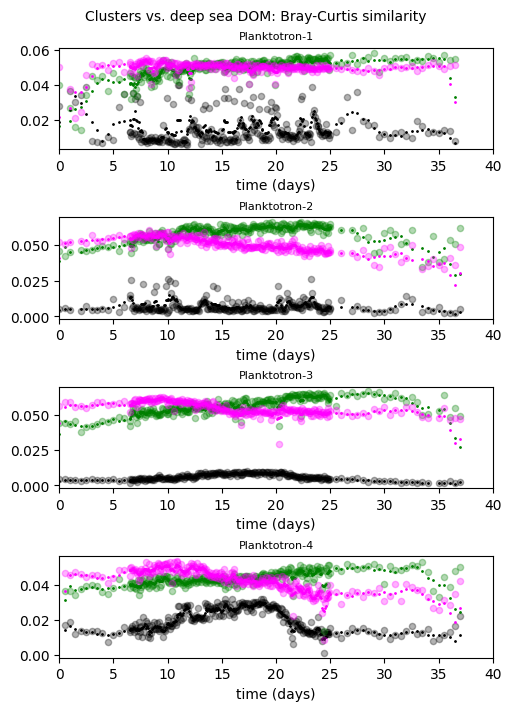

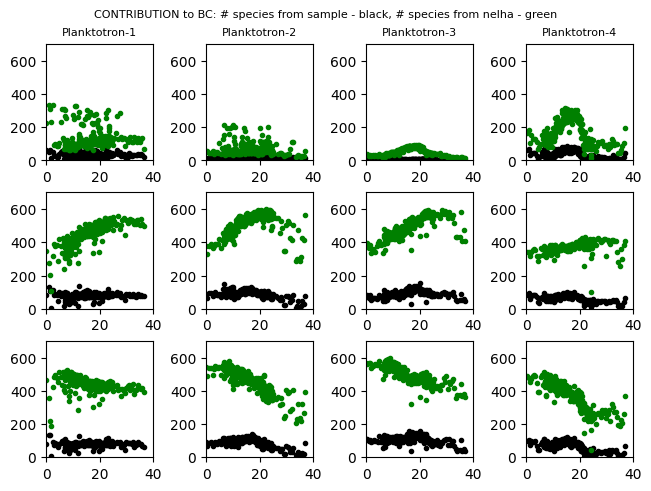

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 28 10:45:16 2023

@author: rajat
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import jaccard, braycurtis, jensenshannon
#import rpy2.robjects as robjects
#from rpy2.robjects.conversion import localconverter
from scipy import stats
from tqdm import tqdm
##################################################################################
plt.rcParams['figure.max_open_warning'] = 20 ## TO SET MAX. FIGs TO 50
plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.autolayout"] = True
##############################################################
nclust = 3 # optimal estimated number of clusters recovered from SI score
N_floor = -4.8 # noise floor in log 10 to filter species out
SI_low_bound = 0.1 # for best clustered species
N_itr = 5 # # of iterations for SI convergence
# only change these values
#################################################################
colors = np.array(["black","green","magenta",
                   "grey","blue",
                    "cyan","orange"]) ## COLOR PALETTE
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsi, tsj = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME CLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsi:tsj] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
xlabels=list(df.columns.values)[tsi:tsj] # extracting column labels for time series 
                                         # labeling
Nelha_start_col = 1109
df_Nelha = df.iloc[:,Nelha_start_col:]
Nelha_data = np.array(df_Nelha.values, dtype = np.float32).transpose()
Nelha_use = np.mean(Nelha_data, axis=0)
Nelha_use = Nelha_use/np.sum(Nelha_use)
Nx = np.shape(Nelha_use)[0]
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]  # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]   # extracting last characters
plank=np.unique(label_sub1)      # determining number of unique characters 
                                      # (planktrtrons)
nplank=len(plank)                     # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype='intc') # storing last digits to compare to
                                            # time points
################################################
## IMPUTING/REPLACING NaN DATA WITH THE OVERALL MEDIAN OF THE DATA SET/TIME SERIES POINT
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='mean') 
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
useful_data = useful_data/useful_data.sum(axis=1)[:,None]
## STANDARD PROCEDURE ENDS
###############################################
### NOISE FILTERING
l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
useful_data = useful_data[:,l_mean > N_floor]
xlab_u = xlab_u[l_mean > N_floor]
### RANK ORDER FILTER
vv = useful_data > 0 ## gives logical matrix with true false
vv = vv*1            ##  converting logicals to binary (0/1)
sum_array = np.sum(vv, axis=0) ##
## arranged indices
#arr_indx = np.argsort(-sum_array)
## to pick indices corresponding to occurrence above X (that we fix)
useful_indx = np.where(sum_array > 100)
useful_data = useful_data.T[useful_indx].T
#Nelha_use = Nelha_use[useful_indx]
xlab_u = xlab_u[useful_indx] # end of rank order filtering
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
Nelha_plnk = [ [] for _ in range(nplank)]   # Nelha per planktotron
xtime = [ [] for _ in range(nplank) ] # time perplanktotron
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                    # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1[1:]:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.double)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1
# scaler = StandardScaler() # scaler to transform the data into z-scored data
for i in range(nplank):
    xxlab[i] = xlab_u
    Nelha_plnk[i] = Nelha_use

num_cores = 4
sscore_samp = [ [] for _ in range(nplank)] # s score per species
sscore_av = [ [] for _ in range(nplank)]   # av. s score (av.over all species)
## CURVE SMOOTHNING PARAMETERS LATER FOR PLOTTING
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
##
for ijk in tqdm(range(N_itr)):
################################################### distance matrix calculation    
    xbc = [ [] for _ in range(nplank)]        # distance matrix per planktotron         
######################################### parallel implementation using 4 cores
    if __name__ == "__main__":
        xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
                                         for i in range(nplank))
    for i in range(nplank):
        xbc[i] = (1.0 - xbc[i][0])
###############################################################################
    # generating cluster labels
    cluster_labels = [ [] for _ in range(nplank)] ## to save cluster labels for 
                                                  ## each planktotron                                         
    clusterer = AgglomerativeClustering(n_clusters=nclust, 
                                        metric='precomputed', 
                                        linkage='average')                                         
    for i in range(nplank):
        cluster_labels[i] = clusterer.fit_predict(xbc[i])
        sscore_samp[i].append(metrics.silhouette_samples(xbc[i], 
                                                         cluster_labels[i], 
                                                         metric='precomputed',
                                                         sample_size=None, 
                                                         random_state=None))
        sscore_av[i].append(metrics.silhouette_score(xbc[i], 
                                                     cluster_labels[i], 
                                                     metric='precomputed',
                                                     sample_size=None, 
                                                     random_state=None))
    if ijk == N_itr-1:       
    #################################################     cluster sorting with size
        temp_labels = [0 for ii in range(nplank)]
        for i in range(nplank):
            xsize = [0 for ii in range(nclust)]
            for j in range(nclust):
                xsize[j] = np.shape(np.where(cluster_labels[i] == j))[1]
            temp_labels[i] = np.argsort(xsize)
        k1 = temp_labels[0][1]
        k2 = temp_labels[0][2]
        temp_labels[0][1] = k2
        temp_labels[0][2] = k1
    ###############################################################################   
        touse = [[[] for i in range(nplank)] for j in range(nclust)]
        xmedian = [[[] for i in range(nplank)] for j in range(nclust)] # median array
        xmean = [[[] for i in range(nplank)] for j in range(nclust)]# mean array
        for_dist = [[[] for i in range(nplank)] for j in range(nclust)]
        Nelha_clus = [[[] for i in range(nplank)] for j in range(nclust)]
        xsmpContrib = [[[] for i in range(nplank)] for j in range(nclust)]
        xNelhaContrib = [[[] for i in range(nplank)] for j in range(nclust)]
        for ii in range(nplank):
            xpart=part[ii].T
            for i in range(nclust):
                xtemp = np.where(cluster_labels[ii]==temp_labels[ii][i])
                touse[i][ii] = xpart[xtemp]
                xmedian[i][ii] = np.median(touse[i][ii], axis = 0)
                xmean[i][ii] = np.mean(touse[i][ii], axis = 0)
                for_dist[i][ii] = np.zeros((Nx,
                                            np.shape(xpart)[1]))
                for_dist[i][ii][xtemp] = xpart[xtemp]
                Nelha_clus[i][ii] = Nelha_use
                xsmpContrib[i][ii] = 1*np.array([(for_dist[i][ii][:,j] < Nelha_use)
                                                 & (for_dist[i][ii][:,j] > 0)
                                                 & (Nelha_use > 0)
                                    for j in range(np.shape(for_dist[i][ii])[1])])
                xNelhaContrib[i][ii] = 1*np.array([(for_dist[i][ii][:,j] > Nelha_use)
                                                   & (for_dist[i][ii][:,j] > 0)
                                                   & (Nelha_use > 0)
                                    for j in range(np.shape(for_dist[i][ii])[1])])                

        dist_Nlhaclus = [[[] for i in range(nplank)] for j in range(nclust)]
        for ii in range(nplank):
            for i in range(nclust):
                dist_Nlhaclus[i][ii] = [1.0 - braycurtis(Nelha_clus[i][ii], 
                                                for_dist[i][ii].T[j])
                                                for j in range(np.shape
                                                               (for_dist[i][ii].T)[0])]
    ###############################################################################
     
    ###############################################################################            
#        fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
#        fig.suptitle(str(nclust)+ '-clusters, median', fontsize=10)
#        for ii in range(nplank):
#            axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
#            for i in range(nclust):
#    ################################### Smoothing Data by Rolling Average with NumPy
#                cumsum_vec = np.convolve(xmedian[i][ii], kernel,
#                                          mode ='same') # for median
#    ###############################################################################            
#                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='k')
#                axs[i,ii].plot(xtime[ii], xmedian[i][ii],'o', markersize=np.sqrt(20.), 
#                                c='k', alpha =0.1 )
#                cumsum_vec = np.convolve(xmean[i][ii], kernel,
#                                              mode ='same') # for mean
#                axs[i,ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.), c='r')
#                axs[i,ii].plot(xtime[ii], xmean[i][ii],'o', markersize=np.sqrt(20.), 
#                                c='r', alpha =0.1 )
#                axs[i,ii].set_xlim([0,40])
#                axs[i,ii].set_yscale('log')
#                axs[i,ii].set_ylim([10**-5,10**-3])
                #plt.savefig('ClusmedianJac'+'.pdf')        
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,7), constrained_layout=True)
        fig.suptitle('Clusters vs. deep sea DOM: Bray-Curtis similarity', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(dist_Nlhaclus[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                             c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], dist_Nlhaclus[i][ii],'o', markersize=np.sqrt(20.),
                              c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])
                axs[ii].set_xlabel('time (days)')
        plt.savefig('NELHASimBC'+'.pdf')

        fig, axs = plt.subplots(nclust,nplank, constrained_layout=True)
        fig.suptitle('CONTRIBUTION to BC: # species from sample - black, # species from nelha - green', fontsize=8)
        for ii in range(nplank):
            axs[0,ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ###############################################################################
                axs[i,ii].plot(xtime[ii], np.sum(xsmpContrib[i][ii], axis =1), '.',
                               c='k', alpha = 1.0 )
                axs[i,ii].plot(xtime[ii], np.sum(xNelhaContrib[i][ii], axis =1),'.',
                               c='g', alpha =1.0 )
                axs[i,ii].set_xlim([0,40])
                axs[i,ii].set_ylim([0,700])
        #plt.savefig('NELHASimJac'+'.pdf')
    
    ################################## Van-Krevelen plots per planktotron per cluster
                
    for i in range(nplank):
        part[i] = part[i][:,sscore_samp[i][ijk] > SI_low_bound]
        xxlab[i] = xxlab[i][sscore_samp[i][ijk] > SI_low_bound]
        #Nelha_plnk[i] = Nelha_plnk[i][sscore_samp[i][ijk] > SI_low_bound]


These results show that the green symbols (second cluster) exhibits higher BC similarity to the Nelha data by the end of the experiment.

##### Details of additional calculation in last figure:

Let $C({S_j}^i)$ and $C^i_\mathrm{Nelha}$ represent the $i^{th}$ species concentration in our sample (cluster $j$) and Nelha data respectively. For BC calculation in general as well as for the following calculation, only species $i$ where both $C({S_j}^i) > 0$ and $C^i_\mathrm{Nelha} > 0$ are considered. We estimate $\mathrm{min}(C({S_j}^i), C^i_\mathrm{Nelha})$ to determine if the contribution to the Bray-Curtis calculation comes from our cluster, or the Nelha sample. In case the contribution comes from our cluster (Nelha), we note this as ${m_j}^i = 1$ ($m^i_\mathrm{Nelha} = 1$) and repeat the procedure for all species in cluster. Fig. shows the result of this calculation for different clusters in our planktotrons. The black (green) symbols highlight $\sum_{i = 1}^{N} {m_j}^i $ ($\sum_{i = 1}^{N} m^i_\mathrm{Nelha}$), i.e. the total number of species contributing to BC calculation from $j^{th}$ cluster (Nelha) as a function of time.

##### Observations:

Total number of species contributing to the BC calculation is higher from the Nelha data (green) in all clusters, i.e. species contributions are lower in Nelha. For cluster 1, the difference between the number of species contributing from Nelha and those contributing from the cluster (black) is lowest. For clusters 2 and 3, this difference is substantially higher. Additionally, we observe that the contribution from Nelha in cluster no. 3 is highest, followed by cluster no. 2, and then no. 1, in the beginning of the experiment. We further observe that as time progresses, there is an overall increase (decrease) in Nelha contribution from cluster no. 2 (no. 3). Since Nelha data is fixed, these changes are likely related to an overall increase (decrease) in species similarity to the Nelha in cluster 2 (cluster 3). On comparing these with the BC calculation, results are in good agreement. This further seems to support the hypothesis by Thorsten that cluster 2 is most similar to Nelha data (but only in the longer time limit). Additional information (a) why do we observe a higher BC similarity with cluster no. 3 in the initial phase of the experiment? (b) other ques? (c) more?


***** Looking at the Jaccard as well as Bray-Curtis results, we can verify that the cluster number 2 as suggested by Thorsten is indeed showing more similarity to Nelha as time progresses. Although, an important point to consider is the similarity of cluster 3 to Nelha in the beginning of the experiment (the preparation for the experiment might be an influence?). As time progresses, cluster 3 evolves in time to lose similarity to Nelha (both in Jaccard as well as BC), while in the meantime, cluster 2 becomes more similar to Nelha.***** 

#### 3. Jensen-Shannon similarity

The Jensen-Shannon distance ($D_\mathrm{JS}$) is a measure of the similarity between two probability distributions. It is based on the Kullback-Leibler divergence ($D_\mathrm{KL}$), but has some notable advantages, including: It is symmetric, meaning that $D_\mathrm{JS}(P,Q) = D_\mathrm{JS}(Q,P)$, given two distributions $P$ and $Q$, while $D_\mathrm{KL}$ is not. Additionally, $D_\mathrm{JS}(P,Q)$ is always finite, even when $P$ and/or $Q$ have zero probability for some events.

$D_\mathrm{JS}$ is given by, 

$D_\mathrm{JS}(P,Q) = \dfrac{D_\mathrm{KL}(P||M) + D_\mathrm{KL}(Q||M)}{2}$

where $M$ is the mean of distributions $P$ and $Q$ given by $M = \dfrac{P+Q}{2}$, and $D_\mathrm{KL}(P||M) = \sum_i P_i\log\left(\dfrac{P_i}{M_i}\right)$. $D_\mathrm{JS} \in [0,1]$, with higher values indicating greater dissimilarity between the two probability distributions being compared. $D_\mathrm{JS} = 0$ indicates that the two distributions are identical, while $D_\mathrm{JS} = 1$ indicates that the distributions are completely different. Similar to previous measures, we define Jensen-Shannon similarity $S_\mathrm{JS} = 1 - D_\mathrm{JS}$ where $S_\mathrm{JS} = 0$ ($1$) when the distributions are completely different (identical). 

###### Black symbols correspond to cluster 1, green symbols to cluster 2 and magenta symbols to cluster 3

100%|██████████| 5/5 [00:32<00:00,  6.44s/it]


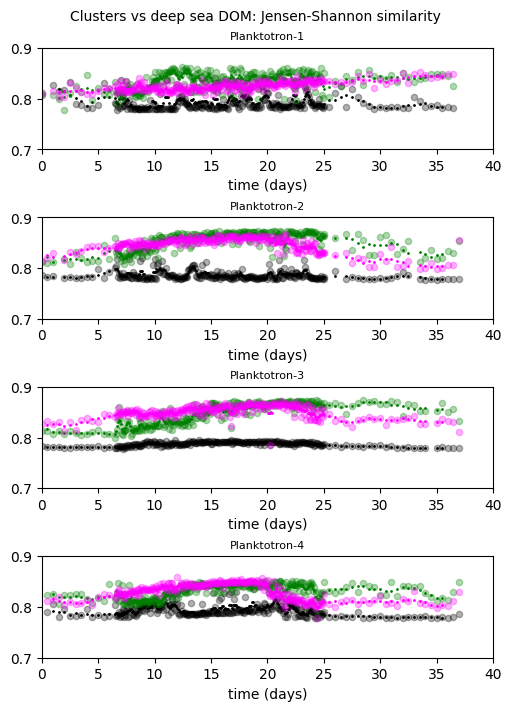

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 28 10:45:16 2023

@author: rajat
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
#from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jensenshannon
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from My_Functions import vankrevelan
from tqdm import tqdm
##################################################################################
plt.rcParams['figure.max_open_warning'] = 20 ## TO SET MAX. FIGs TO 50
plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.autolayout"] = True
##############################################################
nclust = 3 # optimal estimated number of clusters recovered from SI score
N_floor = -4.8 # noise floor in log 10 to filter species out
SI_low_bound = 0.1 # for best clustered species
N_itr = 5 # # number of iterations for SI convergence
# only change these values
#################################################################
colors = np.array(["black","green","magenta",
                   "grey","blue",
                    "cyan","orange"]) ## COLOR PALETTE
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsi, tsj = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME CLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsi:tsj] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
xlabels=list(df.columns.values)[tsi:tsj] # extracting column labels for time series 
                                         # labeling
Nelha_start_col = 1109
df_Nelha = df.iloc[:,Nelha_start_col:]
Nelha_data = np.array(df_Nelha.values, dtype = np.float32).transpose()
Nelha_use = np.mean(Nelha_data, axis=0)
Nelha_use = Nelha_use/np.sum(Nelha_use)
Nx = np.shape(Nelha_use)[0]
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]  # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]   # extracting last characters
plank=np.unique(label_sub1)      # determining number of unique characters 
                                      # (planktrtrons)
nplank=len(plank)                     # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype='intc') # storing last digits to compare to
                                            # time points
################################################
## IMPUTING/REPLACING NaN DATA WITH THE OVERALL MEDIAN OF THE DATA SET/TIME SERIES POINT
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='mean') 
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
useful_data = useful_data/useful_data.sum(axis=1)[:,None]
## STANDARD PROCEDURE ENDS
###############################################
### NOISE FILTERING
l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
useful_data = useful_data[:,l_mean > N_floor]
xlab_u = xlab_u[l_mean > N_floor]
### RANK ORDER FILTER
vv = useful_data > 0 ## gives logical matrix with true false
vv = vv*1            ##  converting logicals to binary (0/1)
sum_array = np.sum(vv, axis=0) ##
## arranged indices
#arr_indx = np.argsort(-sum_array)
## to pick indices corresponding to occurrence above X (that we fix)
useful_indx = np.where(sum_array > 100)
useful_data = useful_data.T[useful_indx].T
#Nelha_use = Nelha_use[useful_indx]
xlab_u = xlab_u[useful_indx] # end of rank order filtering
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
Nelha_plnk = [ [] for _ in range(nplank)]   # Nelha per planktotron
xtime = [ [] for _ in range(nplank) ] # time perplanktotron
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                    # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1[1:]:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.double)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1
# scaler = StandardScaler() # scaler to transform the data into z-scored data
for i in range(nplank):
    xxlab[i] = xlab_u
    Nelha_plnk[i] = Nelha_use
######### PLAYING AROUND
num_cores = 4
sscore_samp = [ [] for _ in range(nplank)] # s score per species
sscore_av = [ [] for _ in range(nplank)]   # av. s score (av.over all species)
## CURVE SMOOTHNING PARAMETERS LATER FOR PLOTTING
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
#################################################
for ijk in tqdm(range(N_itr)):
############################################################# Vankrevelan calc.
    ## Vankrevelan plot calculation
    xClist = [ [] for _ in range(nplank) ]
    xHlist = [ [] for _ in range(nplank) ]
    xNlist = [ [] for _ in range(nplank) ]
    xOlist = [ [] for _ in range(nplank) ]
    xPlist = [ [] for _ in range(nplank) ]
    xSlist = [ [] for _ in range(nplank) ]

    for i in range(nplank):
        xtempvankrev = vankrevelan(xxlab[i])
        xClist[i].append(xtempvankrev['C'])
        xHlist[i].append(xtempvankrev['H'])
        xNlist[i].append(xtempvankrev['N'])
        xOlist[i].append(xtempvankrev['O'])
        xPlist[i].append(xtempvankrev['P'])
        xSlist[i].append(xtempvankrev['S'])
        
        xClist[i]=np.array(xClist[i], dtype=np.float32)
        xHlist[i]=np.array(xHlist[i], dtype=np.float32)
        xNlist[i]=np.array(xNlist[i], dtype=np.float32)
        xOlist[i]=np.array(xOlist[i], dtype=np.float32)
        xPlist[i]=np.array(xPlist[i], dtype=np.float32)
        xSlist[i]=np.array(xSlist[i], dtype=np.float32)
##################################################################
################################################### distance matrix calculation    
    xbc = [ [] for _ in range(nplank)]        # distance matrix per planktotron         
######################################### parallel implementation using 4 cores
    if __name__ == "__main__":
        xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
                                         for i in range(nplank))
    for i in range(nplank):
        xbc[i] = (1.0 - xbc[i][0])
        #np.fill_diagonal(xbc[i],0)
###############################################################################
    # generating cluster labels
    cluster_labels = [ [] for _ in range(nplank)] ## to save cluster labels for 
                                                  ## each planktotron                                         
    clusterer = AgglomerativeClustering(n_clusters=nclust, 
                                        metric='precomputed', 
                                        linkage='average')                                         
    for i in range(nplank):
        cluster_labels[i] = clusterer.fit_predict(xbc[i])
        sscore_samp[i].append(metrics.silhouette_samples(xbc[i], 
                                                         cluster_labels[i], 
                                                         metric='precomputed',
                                                         sample_size=None, 
                                                         random_state=None))
        sscore_av[i].append(metrics.silhouette_score(xbc[i], 
                                                     cluster_labels[i], 
                                                     metric='precomputed',
                                                     sample_size=None, 
                                                     random_state=None))
    if ijk == N_itr-1: # > 0 prints all graphs, ==5 prints the last results       
    #################################################     cluster sorting with size
        temp_labels = [0 for ii in range(nplank)]
        for i in range(nplank):
            xsize = [0 for ii in range(nclust)]
            for j in range(nclust):
                xsize[j] = np.shape(np.where(cluster_labels[i] == j))[1]
            temp_labels[i] = np.argsort(xsize)
        k1 = temp_labels[0][1]
        k2 = temp_labels[0][2]
        temp_labels[0][1] = k2
        temp_labels[0][2] = k1
    ###############################################################################    
        touse = [[[] for i in range(nplank)] for j in range(nclust)]
        xmedian = [[[] for i in range(nplank)] for j in range(nclust)] # median array
        xmean = [[[] for i in range(nplank)] for j in range(nclust)]# mean array
        for_dist = [[[] for i in range(nplank)] for j in range(nclust)]
        Nelha_clus = [[[] for i in range(nplank)] for j in range(nclust)]
        for ii in range(nplank):
            xpart=part[ii].T
            for i in range(nclust):
                xtemp = np.where(cluster_labels[ii]==temp_labels[ii][i])
                touse[i][ii] = xpart[xtemp]
                xmedian[i][ii] = np.median(touse[i][ii], axis = 0)
                xmean[i][ii] = np.mean(touse[i][ii], axis = 0)
                for_dist[i][ii] = np.zeros((Nx,
                                            np.shape(xpart)[1]))
                #for_dist[i][ii] = np.zeros(np.shape(xpart))
                for_dist[i][ii][xtemp] = xpart[xtemp]
                Nelha_clus[i][ii] = Nelha_plnk[ii]
                
        dist_Nlhaclus = [[[] for i in range(nplank)] for j in range(nclust)]
    #    reslt = [[[] for i in range(nplank)] for j in range(nclust)]
        for ii in range(nplank):
            for i in range(nclust):
                dist_Nlhaclus[i][ii] = [1.0 - jensenshannon(np.histogram(Nelha_clus[i][ii], bins=128, density=True)[0], 
                                                np.histogram(for_dist[i][ii].T[j], bins=128, density=True)[0], 2.0)
                                                for j in range(np.shape
                                                               (for_dist[i][ii].T)[0])]
     
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,7), constrained_layout=True)
        fig.suptitle('Clusters vs deep sea DOM: Jensen-Shannon similarity', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(dist_Nlhaclus[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                             c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], dist_Nlhaclus[i][ii],'o', markersize=np.sqrt(20.),
                              c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])
                axs[ii].set_ylim([0.7,0.9])
                axs[ii].set_xlabel('time (days)')
              #  axs[ii].set_yticks([0.1,0.2,0.3])
        plt.savefig('NELHASimJS'+'.pdf')
                
    for i in range(nplank):
        part[i] = part[i][:,sscore_samp[i][ijk] > SI_low_bound]
        xxlab[i] = xxlab[i][sscore_samp[i][ijk] > SI_low_bound]
        #Nelha_plnk[i] = Nelha_plnk[i][sscore_samp[i][ijk] > SI_low_bound]


These results show that the green symbols (second cluster) exhibits higher JS similarity to the Nelha data by the end of the experiment. These results show that apart from the presence-absence and abundances, also the distributions of species in cluster 2 becomes more similar to Nelha as time progresses

## 3) Labile species ?

Here we estimate the labile species per plankototron based on their instantaneous growth and consumption rates. Shown below are the labile species name and the cluster number to which they are assigned. The common labile species in different planktotrons are also shown. Finally, the instantaneous growth rates of these species as a function of time per planktotron, and their time series are also shown in the figures.

100%|██████████| 5/5 [00:31<00:00,  6.40s/it]


 
Planktotron 1
['C9H12O3' 'C11H14O2' 'C10H20OS' 'C10H12O5' 'C12H22N2O2' 'C7H17O7P'
 'C12H11O4P' 'C11H14O5S' 'C12H16O5S' 'C13H18O5S' 'C14H20O5S' 'C15H22O5S'
 'C18H29NO4' 'C18H31NO4' 'C17H30N2O4' 'C18H35NO4' 'C15H30O6S' 'C14H28O7S'
 'C17H30N2O5' 'C15H30O7S' 'C18H31NO6' 'C19H35NO3S' 'C20H39NO3S'
 'C22H37O2PS' 'C31H24N2O' 'C24H44N4O4' 'C33H43N' 'C32H44NOP' 'C27H47N3O7'
 'C26H45O7PS' 'C38H52O3']
[2 2 1 2 2 2 2 3 3 3 3 3 1 1 1 1 3 3 1 3 1 1 1 1 1 2 2 2 1 2 1]
Planktotron 2
['C11H14O2' 'C10H20OS' 'C10H12O5' 'C12H14O4' 'C12H22N2O2' 'C10H23O2PS'
 'C7H17O7P' 'C12H11O4P' 'C12H16O5S' 'C13H18O5S' 'C14H20O5S' 'C15H22O5S'
 'C9H18O10S' 'C14H28O6S' 'C18H31NO4' 'C17H30N2O4' 'C18H35NO4' 'C18H36O5'
 'C18H35NO5' 'C19H35NO3S' 'C18H33NO6' 'C17H30O12S' 'C32H44NOP'
 'C26H45O7PS']
[1 3 1 1 1 2 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 2 1 1]
Planktotron 3
['C11H14O2' 'C10H12O5' 'C12H14O4' 'C12H22N2O2' 'C12H11NO2S' 'C7H17O7P'
 'C12H11O4P' 'C12H16O5S' 'C13H18O5S' 'C14H20O5S' 'C13H24O6S' 'C14H28O6S'
 'C19H17N3O3' 'C14H28O7S'

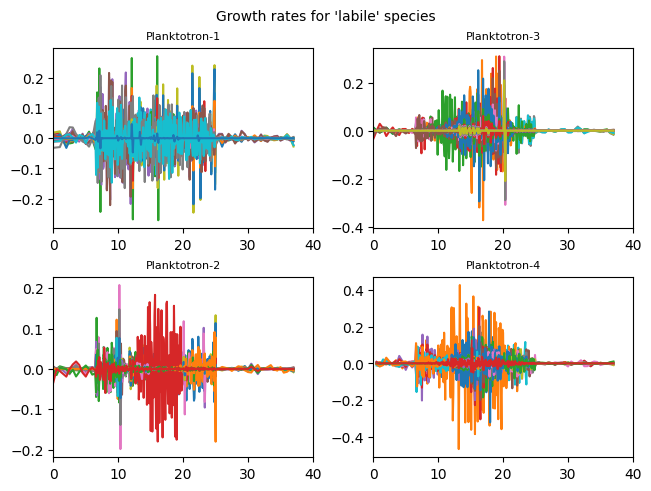

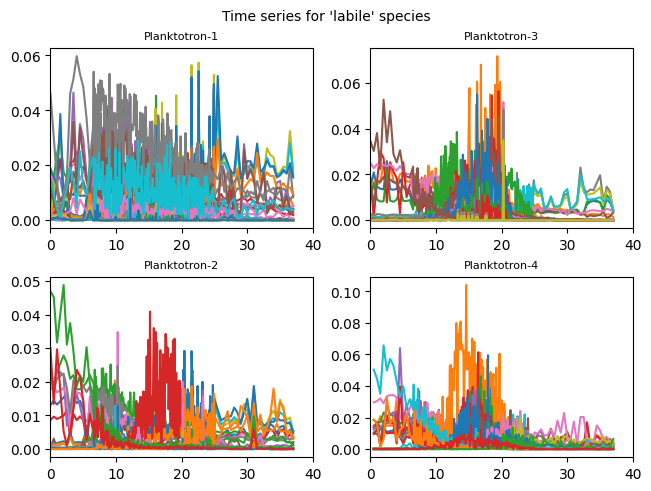

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 28 10:45:16 2023

@author: rajat
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from tqdm import tqdm

##################################################################################
plt.rcParams['figure.max_open_warning'] = 50 ## TO SET MAX. FIGs TO 50
##############################################################
nclust = 3 # optimal estimated number of clusters recovered from SI score
N_floor = -4.85 # noise floor in log 10 to filter species out
SI_low_bound = 0.1 # for best clustered species
N_itr = 5 # # of iterations for SI convergence
# only change these values
#################################################################
colors = np.array(["black","green","magenta",
                   "grey","blue",
                    "cyan","orange"]) ## COLOR PALETTE
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsinitial, tsfinal = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME COLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsinitial:tsfinal] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
xlabels=list(df.columns.values)[tsinitial:tsfinal] # extracting column labels for time series 
                                         # labeling
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]    # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]    # extracting last characters
plank=np.unique(label_sub1)             # determining number of unique characters 
                                        # (planktrtrons)
nplank=len(plank)                       # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype=np.int32) # storing last digits to compare to
                                        # time points
################################################
## IMPUTING/REPLACING NaN DATA WITH THE OVERALL MEDIAN OF THE DATA SET/TIME SERIES POINT
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='mean') 
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
useful_data = useful_data/useful_data.sum(axis=1)[:,None]
## STANDARD PROCEDURE ENDS
###############################################
### NOISE FILTERING
l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
useful_data = useful_data[:,l_mean > N_floor]
xlab_u = xlab_u[l_mean > N_floor]
### RANK ORDER FILTER
vv = useful_data > 0 ## gives logical matrix with true false
vv = vv*1            ##  converting logicals to binary (0/1)
sum_array = np.sum(vv, axis=0) #
useful_indx = np.where(sum_array > 1)
useful_data = useful_data.T[useful_indx].T
xlab_u = xlab_u[useful_indx] # end of rank order filtering
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
xtime = [ [] for _ in range(nplank) ] # time perplanktotron
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                    # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.double)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1
for i in range(nplank):
    xxlab[i] = xlab_u
Rate_thresh = 0.045 
num_cores = 4
sscore_samp = [ [] for _ in range(nplank)] # s score per species
sscore_av = [ [] for _ in range(nplank)]   # av. s score (av.over all species)
## CURVE SMOOTHNING PARAMETERS LATER FOR PLOTTING
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
##
for ijk in tqdm(range(N_itr)):
################################################### distance matrix calculation    
    xbc = [ [] for _ in range(nplank)]        # distance matrix per planktotron         
######################################### parallel implementation using 4 cores
    if __name__ == "__main__":
        xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
                                          for i in range(nplank))
    for i in range(nplank):
        xbc[i] = (1.0 - xbc[i][0])
###############################################################################
    # generating cluster labels
    cluster_labels = [ [] for _ in range(nplank)] ## to save cluster labels for 
                                                  ## each planktotron                                         
    clusterer = AgglomerativeClustering(n_clusters=nclust, 
                                        metric='precomputed', 
                                        linkage='average')                                         
    for i in range(nplank):
        cluster_labels[i] = clusterer.fit_predict(xbc[i])
        sscore_samp[i].append(metrics.silhouette_samples(xbc[i], 
                                                          cluster_labels[i], 
                                                          metric='precomputed',
                                                          sample_size=None, 
                                                          random_state=None))
        sscore_av[i].append(metrics.silhouette_score(xbc[i], 
                                                      cluster_labels[i], 
                                                      metric='precomputed',
                                                      sample_size=None, 
                                                      random_state=None))
    #     ###############################################################################    
    if ijk == N_itr-1:
        ins_growth = [ [] for _ in range(nplank) ]
        labile_indices = [ [] for _ in range(nplank) ]
        labile_species = [ [] for _ in range(nplank) ]
        for i in range(nplank):
            D_species = np.gradient(part[i], axis = 0) # diff. in species values (dn)
            D_time = np.gradient(xtime[i])             # diff. time values (dt)
            ins_growth[i] = np.array([D_species[:,j]/D_time 
                                  for j in range(np.shape(part[i])[1])],
                                    dtype=np.float32)  # dn/dt
            list_1 = np.where(ins_growth[i] > Rate_thresh)[0]
            list_2 = np.where(ins_growth[i] < -Rate_thresh)[0]
            labile_indices[i] = np.intersect1d(list_1, list_2)
          #  print(np.where((ins_growth[i] > Rate_thresh) | 
          #                                (ins_growth[i] < -Rate_thresh)))
          #  labile_indices[i] = np.unique(np.where((ins_growth[i] > Rate_thresh) |
          #                                (ins_growth[i] < -Rate_thresh))[0])
           # print("Labile species - Planktotron "+ str(i+1))
           # print(xxlab[i][labile_indices[i]])
            labile_species[i] = xxlab[i][labile_indices[i]]
        #print("Common Labile species in all Planktotrons")    
        #print(set.intersection(*[set(list) for list in labile_species]))
            
        fig, axs = plt.subplots(2,2, constrained_layout=True)
        fig.suptitle("Growth rates for 'labile' species", fontsize=10)
        k=0
        for ii in range(2):
            for i in range(2):
                axs[i,ii].set_title('Planktotron-'+ str(k+1), fontsize=8)
                axs[i,ii].plot(xtime[k], ins_growth[k][labile_indices[k],:].T)
                axs[i,ii].set_xlim([0,40])
                k = k+1

        fig, axs = plt.subplots(2,2, constrained_layout=True)
        fig.suptitle("Time series for 'labile' species", fontsize=10)
        k=0
        for ii in range(2):
            for i in range(2):
                axs[i,ii].set_title('Planktotron-'+ str(k+1), fontsize=8)
                axs[i,ii].plot(xtime[k], part[k][:,labile_indices[k]])
                axs[i,ii].set_xlim([0,40])
                k = k+1
                        
    for i in range(nplank):
        part[i] = part[i][:,sscore_samp[i][ijk] > SI_low_bound]
        xxlab[i] = xxlab[i][sscore_samp[i][ijk] > SI_low_bound]

print(' ')
for i in range(nplank):
    print("Planktotron "+str(i+1))
    print(labile_species[i])
    print(cluster_labels[i][labile_indices[i]]+1)

print("Common Labile species in all Planktotrons")    
print(reduce(np.intersect1d, (labile_species[0], labile_species[1], 
                              labile_species[2], labile_species[3])))

#### (NEW) Calculation of diversity indices based on Front. Mar. Sci., 30 June 2017 Volume 4 - 2017 | https://doi.org/10.3389/fmars.2017.00194

100%|██████████| 6/6 [07:07<00:00, 71.27s/it] 


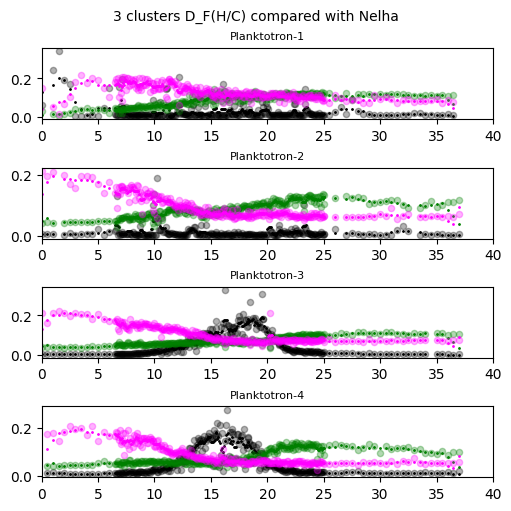

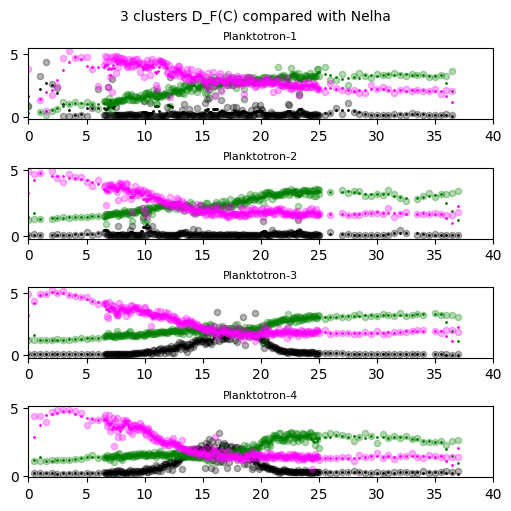

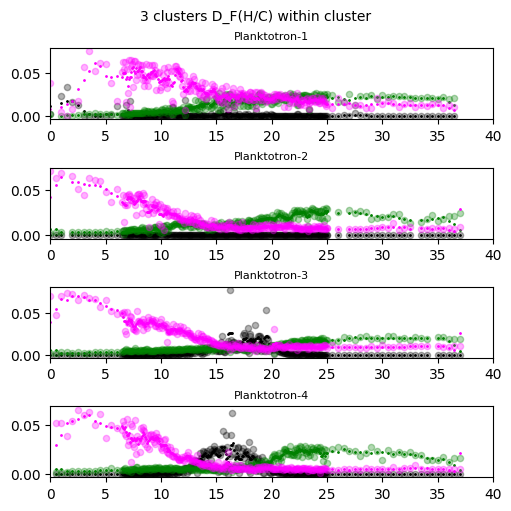

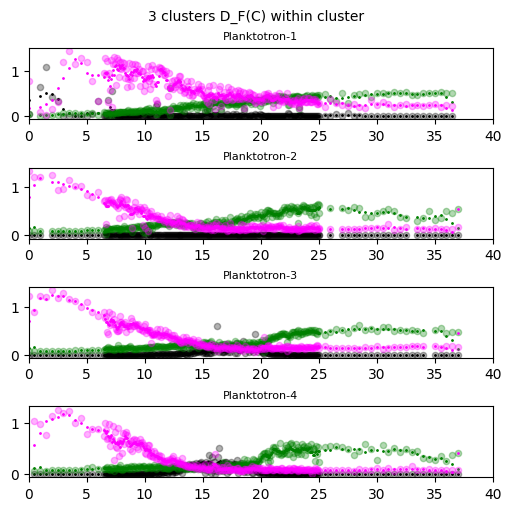

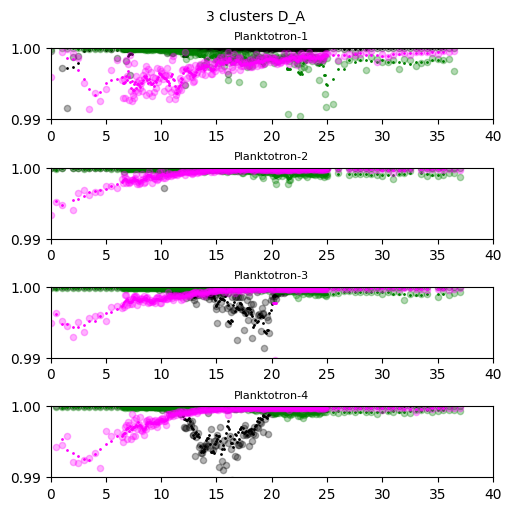

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 28 10:45:16 2023

@author: rajat
"""
## general calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## for clustering calls
from scipy import stats
#import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
## for n(cluster) optimization
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from My_Functions import vankrevelan, Oparam, selfOparam
from tqdm import tqdm
##################################################################################
plt.rcParams['figure.max_open_warning'] = 50 ## TO SET MAX. FIGs TO 50
##############################################################
nclust = 3 # optimal estimated number of clusters recovered from SI score
N_floor = -4.8 # noise floor in log 10 to filter species out
SI_low_bound = 0.1 # for best clustered species
N_itr = 6 # # number of iterations for SI convergence
# only change these values
#################################################################
colors = np.array(["black","green","magenta",
                   "grey","blue",
                    "cyan","orange"]) ## COLOR PALETTE
######################################
df = pd.read_csv('data_big09082023.csv') # read data from file into a dataframe
dftime = pd.read_excel('Timepoints_Zeiten.xlsx') # read time reference data
idxsps = 5 ## AXIS LABEL FOR NAMES OF CHEMICAL SPECIES
tsi, tsj = 60, 1084  ## INITIAL AND FINAL COLUMNS WITH TIME SERIES DATA
df1 = df.iloc[:,idxsps] ## DATA FRAME COLUMN WITH NAMES OF SPECIES
df2 = df.iloc[:, tsi:tsj] ## DATA FRAME COLUMNS WITH TIME SERIES 
res = pd.concat([df1, df2], axis=1, join='inner') ## NEW COMBINED DATA FRAME TO WORK WITH
data=res.values ## VALUES FROM THE DATA FRAME
data=data.transpose()  # transposing data matrix
use_data = data[1:]    # new time series data to use
xlab = data[0,:]       # extracting species names/first row with 
                       # species names
Nelha_labels = xlab    # Storing Nelha labels                   
xlabels=list(df.columns.values)[tsi:tsj] # extracting column labels for time series 
                                         # labeling
Nelha_start_col = 1109
df_Nelha = df.iloc[:,Nelha_start_col:]
Nelha_data = np.array(df_Nelha.values, dtype = np.float32).T
Nelha_use = np.mean(Nelha_data, axis=0)
Nelha_use = Nelha_use/np.sum(Nelha_use)
Nx = np.shape(Nelha_use)[0]
############################################ Determining number of planktotrons
label_sub1=[x[0:2] for x in xlabels]  # extracting first 3 characters
label_sub2=[x[3:6] for x in xlabels]   # extracting last characters
plank=np.unique(label_sub1)      # determining number of unique characters 
                                      # (planktrtrons)
nplank=len(plank)                     # number of unique chars./planktotrons
xtnp=np.array(label_sub2, dtype='intc') # storing last digits to compare to
                                            # time points
################################################
## IMPUTING/REPLACING NaN DATA WITH THE OVERALL MEDIAN OF THE DATA SET/TIME SERIES POINT
impute_mode_all = SimpleImputer(missing_values=np.nan, strategy='mean') 
useful_data = use_data
xlab_u = xlab
useful_data = np.array(useful_data, dtype=np.float32)
useful_data = impute_mode_all.fit_transform(useful_data)
## normalizing (dividing) by the total intensity for all species at each time point
useful_data = useful_data/useful_data.sum(axis=1)[:,None]
## STANDARD PROCEDURE ENDS
###############################################
### NOISE FILTERING
l_mean = np.log10(np.mean(np.array(useful_data, dtype = np.float32), axis=0))
useful_data = useful_data[:,l_mean > N_floor]
xlab_u = xlab_u[l_mean > N_floor]
### RANK ORDER FILTER
vv = useful_data > 0 ## gives logical matrix with true false
vv = vv*1            ##  converting logicals to binary (0/1)
sum_array = np.sum(vv, axis=0) ##
## arranged indices
#arr_indx = np.argsort(-sum_array)
## to pick indices corresponding to occurrence above X (that we fix)
useful_indx = np.where(sum_array > 100)
useful_data = useful_data.T[useful_indx].T
#Nelha_use = Nelha_use[useful_indx]
xlab_u = xlab_u[useful_indx] # end of rank order filtering
################################################
part = [ [] for _ in range(nplank) ] # part[j] to save jth cluster
Nelha_plnk = [ [] for _ in range(nplank)]   # Nelha per planktotron
xtime = [ [] for _ in range(nplank) ] # time perplanktotron
Tpart = [ [] for _ in range(nplank) ]
Xpart = [ [] for _ in range(nplank) ]
xxlab = [ [] for _ in range(nplank) ]
k=0
ik=0                    # was = 1 because we were using file with labels before
xlen=0
for x in plank:
    for xx in label_sub1[1:]:
        if x == xx:
            part[k].append(useful_data[ik,:]) 
            ik=ik+1
    part[k]=np.array(part[k], dtype=np.float32)
    for i in range(np.shape(part[k])[0]):
            xtime[k].append(dftime.values[xtnp[i+xlen],1])
    xlen=xlen+np.shape(part[k])[0]
    xtime[k] = np.array(xtime[k])
    k=k+1
# scaler = StandardScaler() # scaler to transform the data into z-scored data
for i in range(nplank):
    xxlab[i] = xlab_u
#    Nelha_plnk[i] = Nelha_use
######### PLAYING AROUND
num_cores = 4
sscore_samp = [ [] for _ in range(nplank)] # s score per species
sscore_av = [ [] for _ in range(nplank)]   # av. s score (av.over all species)
## CURVE SMOOTHNING PARAMETERS LATER FOR PLOTTING
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
#################################################
for ijk in tqdm(range(N_itr)):
############################################################# Vankrevelan calc.
    ## Vankrevelan plot calculation
    xClist = [ [] for _ in range(nplank) ]
    xHlist = [ [] for _ in range(nplank) ]
    xNlist = [ [] for _ in range(nplank) ]
    xOlist = [ [] for _ in range(nplank) ]
    xPlist = [ [] for _ in range(nplank) ]
    xSlist = [ [] for _ in range(nplank) ]
    
    xtempvankrev = vankrevelan(Nelha_labels)
    NelhaClist = np.array(xtempvankrev['C'], dtype=np.float32)
    NelhaHlist = np.array(xtempvankrev['H'], dtype=np.float32)
    NelhaNlist = np.array(xtempvankrev['N'], dtype=np.float32)
    NelhaOlist = np.array(xtempvankrev['O'], dtype=np.float32)
    NelhaPlist = np.array(xtempvankrev['P'], dtype=np.float32)
    NelhaSlist = np.array(xtempvankrev['S'], dtype=np.float32)
    NelhaHbyC = NelhaHlist/NelhaClist # CALCULATED H/C RATIO
    
    for i in range(nplank):
        
        xtempvankrev = vankrevelan(xxlab[i])
        xClist[i].append(xtempvankrev['C'])
        xHlist[i].append(xtempvankrev['H'])
        xNlist[i].append(xtempvankrev['N'])
        xOlist[i].append(xtempvankrev['O'])
        xPlist[i].append(xtempvankrev['P'])
        xSlist[i].append(xtempvankrev['S'])
        
        xClist[i]=np.array(xClist[i], dtype=np.float32)
        xHlist[i]=np.array(xHlist[i], dtype=np.float32)
        xNlist[i]=np.array(xNlist[i], dtype=np.float32)
        xOlist[i]=np.array(xOlist[i], dtype=np.float32)
        xPlist[i]=np.array(xPlist[i], dtype=np.float32)
        xSlist[i]=np.array(xSlist[i], dtype=np.float32)
##################################################################
################################################### distance matrix calculation    
    xbc = [ [] for _ in range(nplank)]        # distance matrix per planktotron         
######################################### parallel implementation using 4 cores
    if __name__ == "__main__":
        xbc = Parallel(n_jobs=num_cores)(delayed(stats.spearmanr)(part[i]) 
                                         for i in range(nplank))
    for i in range(nplank):
        xbc[i] = (1.0 - xbc[i][0])
###############################################################################
    # generating cluster labels
    cluster_labels = [ [] for _ in range(nplank)] ## to save cluster labels for 
                                                  ## each planktotron                                         
    clusterer = AgglomerativeClustering(n_clusters=nclust, 
                                        metric='precomputed', 
                                        linkage='average')                                         
    for i in range(nplank):
        cluster_labels[i] = clusterer.fit_predict(xbc[i])
        sscore_samp[i].append(metrics.silhouette_samples(xbc[i], 
                                                         cluster_labels[i], 
                                                         metric='precomputed',
                                                         sample_size=None, 
                                                         random_state=None))
        sscore_av[i].append(metrics.silhouette_score(xbc[i], 
                                                     cluster_labels[i], 
                                                     metric='precomputed',
                                                     sample_size=None, 
                                                     random_state=None))
    if ijk == N_itr-1: # > 0 prints all graphs, ==5 prints the last results       
    #################################################     cluster sorting with size
        temp_labels = [0 for ii in range(nplank)]
        for i in range(nplank):
            xsize = [0 for ii in range(nclust)]
            for j in range(nclust):
                xsize[j] = np.shape(np.where(cluster_labels[i] == j))[1]
            temp_labels[i] = np.argsort(xsize)
        k1 = temp_labels[0][1]
        k2 = temp_labels[0][2]
        temp_labels[0][1] = k2
        temp_labels[0][2] = k1
    ###############################################################################    
        touse = [[[] for i in range(nplank)] for j in range(nclust)]
        D_A = [[[] for i in range(nplank)] for j in range(nclust)]
        touseHbyC = [[[] for i in range(nplank)] for j in range(nclust)]
        touseC = [[[] for i in range(nplank)] for j in range(nclust)]
        D_FCHbyC = [[[] for i in range(nplank)] for j in range(nclust)]
        D_FCC = [[[] for i in range(nplank)] for j in range(nclust)]
        D_FCselfHbyC = [[[] for i in range(nplank)] for j in range(nclust)]
        D_FCselfC = [[[] for i in range(nplank)] for j in range(nclust)]
        for ii in range(nplank):
            xpart=part[ii].T
            for i in range(nclust):
                xtemp = np.where(cluster_labels[ii]==temp_labels[ii][i])
                touse[i][ii] = xpart[xtemp]
                touseHbyC[i][ii] = (xHlist[ii]/xClist[ii])[0,:][xtemp]
                touseC[i][ii] = xClist[ii][0,:][xtemp]
                D_A[i][ii] = [1 - np.sum(np.square(touse[i][ii][:,j])) 
                       for j in range(np.shape(touse[i][ii])[1])]
                D_FCHbyC[i][ii] = [Oparam(touse[i][ii][:,j],
                                              Nelha_use,
                                              touseHbyC[i][ii],
                                              NelhaHbyC) 
                                        for j in range(np.shape(touse[i][ii])[1])]
                D_FCC[i][ii] = [Oparam(touse[i][ii][:,j],
                                              Nelha_use,
                                              touseC[i][ii],
                                              NelhaClist) 
                                        for j in range(np.shape(touse[i][ii])[1])]
                D_FCselfHbyC[i][ii] = [selfOparam(touse[i][ii][:,j], 
                                                  touseHbyC[i][ii]) 
                                       for j in range(np.shape(touse[i][ii])[1])]
                D_FCselfC[i][ii] = [selfOparam(touse[i][ii][:,j], 
                                                  touseC[i][ii]) 
                                       for j in range(np.shape(touse[i][ii])[1])]
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,5), constrained_layout=True)
        fig.suptitle(str(nclust)+ ' clusters D_F(H/C) compared with Nelha', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(D_FCHbyC[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                              c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], D_FCHbyC[i][ii],'o', markersize=np.sqrt(20.),
                              c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])
        plt.savefig("OP1.svg")
        
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,5), constrained_layout=True)
        fig.suptitle(str(nclust)+ ' clusters D_F(C) compared with Nelha', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(D_FCC[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                              c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], D_FCC[i][ii],'o', markersize=np.sqrt(20.),
                              c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])
        plt.savefig("OP2.svg")
        
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,5), constrained_layout=True)
        fig.suptitle(str(nclust)+ ' clusters D_F(H/C) within cluster', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(D_FCselfHbyC[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                              c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], D_FCselfHbyC[i][ii],'o', markersize=np.sqrt(20.),
                              c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])
        plt.savefig("OP3.svg")        
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,5), constrained_layout=True)
        fig.suptitle(str(nclust)+ ' clusters D_F(C) within cluster', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(D_FCselfC[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                              c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], D_FCselfC[i][ii],'o', markersize=np.sqrt(20.),
                              c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])    
        plt.savefig("OP4.svg")
    ###############################################################################
        fig, axs = plt.subplots(nplank,1,figsize=(5,5), constrained_layout=True)
        fig.suptitle(str(nclust)+ ' clusters D_A', fontsize=10)
        for ii in range(nplank):
            axs[ii].set_title('Planktotron-'+ str(ii+1), fontsize=8)
            for i in range(nclust):
    ################################### Smoothing Data by Rolling Average with NumPy
                cumsum_vec = np.convolve(D_A[i][ii], kernel,
                                          mode ='same')
    ###############################################################################
                axs[ii].plot(xtime[ii], cumsum_vec,'o', markersize=np.sqrt(1.),
                              c=colors[i],label='cluster '+str(i+1))
                axs[ii].plot(xtime[ii], D_A[i][ii],'o', markersize=np.sqrt(20.),
                              c=colors[i], alpha =0.3 )
                axs[ii].set_xlim([0,40])
                axs[ii].set_ylim([0.99,1])
        plt.savefig("OP5.svg")
    for i in range(nplank):
        part[i] = part[i][:,sscore_samp[i][ijk] > SI_low_bound]
        xxlab[i] = xxlab[i][sscore_samp[i][ijk] > SI_low_bound]
